In [1]:
#Import packages
import numpy as np
from multicontact_learning_local_objectives.python.rhp_plan.rhp_utils import * #Need get Init Config from global frame Function 
import os
import pickle
from multicontact_learning_local_objectives.python.machine_learning.ml_utils import *
import matplotlib.pyplot as plt #Matplotlib
import time
import shutil
import sys
from multicontact_learning_local_objectives.python.rhp_plan.rhp_utils import *

np.set_printoptions(precision=4)

In [2]:
#--------------
#Set up for Directories
#   Define Working Directory
workingDirectory = "/home/jiayu/Desktop/MLP_DataSet/Rubbles_RegretOneStep"
print("Working folder: ", workingDirectory)
#   Define Tracking RollOuts Path
TrackingExpPath = workingDirectory + "/" + "NN_TrackTraining_All_Aug_1StepBeforeFail_2Time"
if not (os.path.isdir(TrackingExpPath)):
    raise Exception("Fault Tracking RollOut Path")
else:
    print("Tracking Exp RollOut folder: ", TrackingExpPath)
#   Define Ground Truth RollOuts Path
GroundTruthPath = workingDirectory + "/" + "CleanTrainingSetRollOuts_All_Backup"
if not (os.path.isdir(GroundTruthPath)):
    raise Exception("Fault Ground Truth RollOut Path")
else:
    print("Ground Truth RollOut folder: ", GroundTruthPath)
    
maxStepIndexbeforeFail = 28
print("We collect Maximum the ", str(maxStepIndexbeforeFail), "-th step before the failed step")


Working folder:  /home/jiayu/Desktop/MLP_DataSet/Rubbles_RegretOneStep
Tracking Exp RollOut folder:  /home/jiayu/Desktop/MLP_DataSet/Rubbles_RegretOneStep/NN_TrackTraining_All_Aug_1StepBeforeFail_2Time
Ground Truth RollOut folder:  /home/jiayu/Desktop/MLP_DataSet/Rubbles_RegretOneStep/CleanTrainingSetRollOuts_All_Backup
We collect Maximum the  28 -th step before the failed step


In [3]:
#   Define Number of file proccessed
total_file_num = 0
failed_file_num = 0
success_file_num = 0

#   Get File names in the Local Obj Tracking Exp Folder
TrackingExpfilenames = os.listdir(TrackingExpPath)

success_error_all = []
failed_error_all = []

diff_threshold = 0.04
large_error_cnt = 0

#Loop over all the tracking exp files
for TrackingExp_filename in TrackingExpfilenames:

    if ".p" in TrackingExp_filename:#a data file
        
        print("Process Tracking Exp File: ",TrackingExp_filename)
        total_file_num = total_file_num + 1 #Process one file
        
        #Load Tracking Exp data
        with open(TrackingExpPath + '/' +TrackingExp_filename, 'rb') as f:
            TrackingExp_data= pickle.load(f)
        
        #Load Ground Truth data
        #   Get Ground Truth File name
        GroundTruthFileName_StartingIdx = TrackingExp_data["LocalObjSettings"]["GroundTruthTraj"].find("/Group")
        GroundTruthFileName = TrackingExp_data["LocalObjSettings"]["GroundTruthTraj"][GroundTruthFileName_StartingIdx+1:]
        GroundTruth_file_path = GroundTruthPath + '/' + GroundTruthFileName
        with open(GroundTruth_file_path, 'rb') as f:
            GroundTruth_data= pickle.load(f)
            
        #Compare Error in the Global Frame (Environment is the same, only compare state)
        if len(TrackingExp_data["SingleOptResultSavings"]) < TrackingExp_data["Num_of_Rounds"] and len(TrackingExp_data["SingleOptResultSavings"]) > 0: #also need to filter out the cases with 0 step failed
            #Failed Tracking Exp
            print("- Failed Tracking Exp")
            failed_file_num = failed_file_num + 1
            
            #Loop Over all the rounds
            err_list_temp = []
            for beforeFailIdx in range(1, maxStepIndexbeforeFail+1):
                
                roundIdx_of_interst = len(TrackingExp_data["SingleOptResultSavings"])-beforeFailIdx
                
                if roundIdx_of_interst > 0:
                    print(roundIdx_of_interst)
                
                    TrackingExp_SingleOptResult = TrackingExp_data["SingleOptResultSavings"][roundIdx_of_interst]
                    TrackingExp_InitConfig_Temp, TrackingExp_TerminalConfig_Temp = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=TrackingExp_SingleOptResult)
                    TrackingExp_State = np.array([TrackingExp_InitConfig_Temp["x_init"],TrackingExp_InitConfig_Temp["y_init"],TrackingExp_InitConfig_Temp["z_init"],
                                                  TrackingExp_InitConfig_Temp["xdot_init"],TrackingExp_InitConfig_Temp["ydot_init"],TrackingExp_InitConfig_Temp["zdot_init"],
                                                  TrackingExp_InitConfig_Temp["Lx_init"],TrackingExp_InitConfig_Temp["Ly_init"],TrackingExp_InitConfig_Temp["Lz_init"],
                                                  TrackingExp_InitConfig_Temp["PLx_init"],TrackingExp_InitConfig_Temp["PLy_init"],TrackingExp_InitConfig_Temp["PLz_init"],
                                                  TrackingExp_InitConfig_Temp["PRx_init"],TrackingExp_InitConfig_Temp["PRy_init"],TrackingExp_InitConfig_Temp["PRz_init"]])


                    GroundTruth_SingleOptResult = GroundTruth_data["SingleOptResultSavings"][roundIdx_of_interst]
                    GroundTruth_InitConfig_Temp, GroundTruth_TerminalConfig_Temp = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=GroundTruth_SingleOptResult)
                    GroundTruth_State = np.array([GroundTruth_InitConfig_Temp["x_init"],GroundTruth_InitConfig_Temp["y_init"],GroundTruth_InitConfig_Temp["z_init"],
                                                  GroundTruth_InitConfig_Temp["xdot_init"],GroundTruth_InitConfig_Temp["ydot_init"],GroundTruth_InitConfig_Temp["zdot_init"],
                                                  GroundTruth_InitConfig_Temp["Lx_init"],GroundTruth_InitConfig_Temp["Ly_init"],GroundTruth_InitConfig_Temp["Lz_init"],
                                                  GroundTruth_InitConfig_Temp["PLx_init"],GroundTruth_InitConfig_Temp["PLy_init"],GroundTruth_InitConfig_Temp["PLz_init"],
                                                  GroundTruth_InitConfig_Temp["PRx_init"],GroundTruth_InitConfig_Temp["PRy_init"],GroundTruth_InitConfig_Temp["PRz_init"]])

                #Compute Error
                error_vec = np.linalg.norm(TrackingExp_State - GroundTruth_State)
                err_list_temp.append(error_vec)
                
                if error_vec > diff_threshold:
                    large_error_cnt = large_error_cnt + 1
            
            failed_error_all.append(err_list_temp)
            # print(err_list_temp)
            # fig=plt.figure();   ax = fig.gca()
            # plt.plot(err_list_temp)
            # plt.show()
            #             TrackingExp_InitConfig, TrackingExp_TerminalConfig = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=SingleOptResult_n_StepsBeforeFail)

        elif len(TrackingExp_data["SingleOptResultSavings"]) == TrackingExp_data["Num_of_Rounds"]:
            #Successful Tracking Exp
            print("- Successful Tracking Exp")
            success_file_num = success_file_num + 1

            #Loop Over all the rounds
            err_list_temp = []
            for roundIdx in range(len(TrackingExp_data["SingleOptResultSavings"])):
                TrackingExp_SingleOptResult = TrackingExp_data["SingleOptResultSavings"][roundIdx]
                TrackingExp_InitConfig_Temp, TrackingExp_TerminalConfig_Temp = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=TrackingExp_SingleOptResult)
                TrackingExp_State = np.array([TrackingExp_InitConfig_Temp["x_init"],TrackingExp_InitConfig_Temp["y_init"],TrackingExp_InitConfig_Temp["z_init"],
                                              TrackingExp_InitConfig_Temp["xdot_init"],TrackingExp_InitConfig_Temp["ydot_init"],TrackingExp_InitConfig_Temp["zdot_init"],
                                              TrackingExp_InitConfig_Temp["Lx_init"],TrackingExp_InitConfig_Temp["Ly_init"],TrackingExp_InitConfig_Temp["Lz_init"],
                                              TrackingExp_InitConfig_Temp["PLx_init"],TrackingExp_InitConfig_Temp["PLy_init"],TrackingExp_InitConfig_Temp["PLz_init"],
                                              TrackingExp_InitConfig_Temp["PRx_init"],TrackingExp_InitConfig_Temp["PRy_init"],TrackingExp_InitConfig_Temp["PRz_init"]])
                
                
                GroundTruth_SingleOptResult = GroundTruth_data["SingleOptResultSavings"][roundIdx]
                GroundTruth_InitConfig_Temp, GroundTruth_TerminalConfig_Temp = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=GroundTruth_SingleOptResult)
                GroundTruth_State = np.array([GroundTruth_InitConfig_Temp["x_init"],GroundTruth_InitConfig_Temp["y_init"],GroundTruth_InitConfig_Temp["z_init"],
                                              GroundTruth_InitConfig_Temp["xdot_init"],GroundTruth_InitConfig_Temp["ydot_init"],GroundTruth_InitConfig_Temp["zdot_init"],
                                              GroundTruth_InitConfig_Temp["Lx_init"],GroundTruth_InitConfig_Temp["Ly_init"],GroundTruth_InitConfig_Temp["Lz_init"],
                                              GroundTruth_InitConfig_Temp["PLx_init"],GroundTruth_InitConfig_Temp["PLy_init"],GroundTruth_InitConfig_Temp["PLz_init"],
                                              GroundTruth_InitConfig_Temp["PRx_init"],GroundTruth_InitConfig_Temp["PRy_init"],GroundTruth_InitConfig_Temp["PRz_init"]])
                
                #Compute Error
                error_vec = np.linalg.norm(TrackingExp_State - GroundTruth_State)
                err_list_temp.append(error_vec)
                
                if error_vec > diff_threshold:
                    large_error_cnt = large_error_cnt + 1
                    
            print(err_list_temp)
            
            success_error_all.append(err_list_temp)



Process Tracking Exp File:  Group3_temp1633718182.2112195.p
- Failed Tracking Exp
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group18_temp1633733384.4414787.p
- Successful Tracking Exp
[0.0, 0.018636347735379682, 0.07238389553491971, 0.07464470411102482, 0.04841076549272088, 0.03345400008101068, 0.03333641348730591, 0.11857910302913528, 0.0357021447302848, 0.03708185227143881, 0.027373550648622604, 0.01494274369697226, 0.031661125047774324, 0.031056861493783783, 0.03864265202018675, 0.028214657406595713, 0.027070605065790433, 0.03429145592971943, 0.042507789218216664, 0.029322745351940398, 0.04179096787170738, 0.056468875213905645, 0.07743947532246818, 0.08155718461474433, 0.033674939643107964, 0.05459158577223676, 0.0705426181576435, 0.06973891700472562, 0.07729768495727397, 0.06885885383942426]
Process Tracking Exp File:  Group16_temp1633725574.2999408.p
- Failed Tracking Exp
1
Process Tracking Exp File:  Group9_temp1633707897.5388951.p
- Successful

14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group1_temp1633735251.9855106.p
- Failed Tracking Exp
7
6
5
4
3
2
1
Process Tracking Exp File:  Group9_temp1633721812.492011.p
- Successful Tracking Exp
[0.0, 0.03529819811371902, 0.047884241753182476, 0.05088479666513902, 0.060621763885814056, 0.07984418075148497, 0.0965759076958031, 0.08117548756327672, 0.06678365306977886, 0.06986934414107568, 0.057524645730547344, 0.1284044743667048, 0.11225401201953635, 0.06841839987848913, 0.05799688551878721, 0.05050429245850359, 0.03918842628554149, 0.05569888918341523, 0.04445402684382784, 0.03184954866543685, 0.04002122845595311, 0.04452382404291065, 0.04146216665253145, 0.05968340477518272, 0.06235615479817151, 0.04635489155756861, 0.04421418824049499, 0.06244728702713177, 0.07127363823349214, 0.06954729122914127]
Process Tracking Exp File:  Group7_temp1633714970.3270364.p
- Successful Tracking Exp
[0.0, 0.009387142922175979, 0.04119818574598471, 0.060487749895619995, 0.07155862986

- Successful Tracking Exp
[0.0, 0.042439392166931135, 0.03841571475147041, 0.027696628413231752, 0.037671073035189906, 0.03904993493929691, 0.03305944990387735, 0.025873044299818966, 0.0316218378003846, 0.03412779436196168, 0.03874175042486976, 0.02917376845379224, 0.036621078803895445, 0.029225571423003763, 0.03696056752646692, 0.023877798920154795, 0.03893094486994074, 0.040258034690700446, 0.027697526428254158, 0.021837570736901877, 0.02944054217005535, 0.03388226548527313, 0.034378949933308436, 0.04793077149496788, 0.04628968170767636, 0.0507092426048602, 0.04320727081226125, 0.035175169871510564, 0.037113644902379526, 0.039515783924540845]
Process Tracking Exp File:  Group11_temp1633720882.48113.p
- Successful Tracking Exp
[0.0, 0.09353881764322247, 0.08579759407903882, 0.03184007673941932, 0.04123060316657374, 0.09760247363472402, 0.1039078186940159, 0.03800383709383768, 0.0209426332398276, 0.02251207029236965, 0.028468972480175672, 0.02862321285129661, 0.02126575457458344, 0.015

- Successful Tracking Exp
[0.0, 0.03280555540461011, 0.03678437745317085, 0.036884791684166696, 0.04835567548285439, 0.04238477030591002, 0.03430391884961687, 0.02634410765615666, 0.03347431541907348, 0.03938046803173017, 0.03040454414708089, 0.04380908074745989, 0.04413256543003261, 0.0687429694225282, 0.07030045879591532, 0.04389116366247516, 0.0388065251267341, 0.049252736351424325, 0.06159475219320457, 0.14666772237504655, 0.1573148896887239, 0.030121779154621612, 0.028049468730235835, 0.024562097797184566, 0.042547746595770264, 0.04164209957922567, 0.03827139158169103, 0.04568728457339461, 0.046337079156716, 0.037559963566995425]
Process Tracking Exp File:  Group7_temp1633720258.724693.p
- Successful Tracking Exp
[0.0, 0.017187789254853685, 0.04189981428392346, 0.03609104169794, 0.06689303126163636, 0.07602536866801235, 0.07091823519540737, 0.06505419685556106, 0.06574514106321659, 0.06084904227416605, 0.05627823180628246, 0.061269917025720225, 0.051384639978156864, 0.050289982444

[0.0, 0.01644804642179729, 0.055984354021200174, 0.07539039225603332, 0.06576534369517538, 0.03952595711284514, 0.04606765934515913, 0.048639632095567674, 0.040959942113340454, 0.08620705730331558, 0.03662660606951852, 0.06390235461569953, 0.07678754068668477, 0.08182696685412871, 0.04924691265341358, 0.0599846875620269, 0.12627304645759843, 0.11936641255568338, 0.051038525167880266, 0.06289735921416137, 0.07320932310109696, 0.1572918313558304, 0.109441215489658, 0.05292075809855494, 0.06793851492180751, 0.05775848668592338, 0.04084037127764079, 0.040989991872245904, 0.04598493227560818, 0.03976815162937365]
Process Tracking Exp File:  Group19_temp1633718192.7664878.p
- Failed Tracking Exp
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group1_temp1633733405.481468.p
- Successful Tracking Exp
[0.0, 0.01800724068243821, 0.030162224256271554, 0.05554433323427874, 0.02491869881303574, 0.03413888327063172, 0.04473778625626713, 0.04474476207674661, 0.04954360749113311, 0.13878718771500184,

- Successful Tracking Exp
[0.0, 0.06636770309743538, 0.06456336916997765, 0.03339989810095785, 0.03704997301302046, 0.04140892974672464, 0.024065644727443655, 0.026382969920738464, 0.03192059551768649, 0.05612675557383823, 0.05624817506934315, 0.03757511647222388, 0.029858953630252313, 0.033597122056624434, 0.045080953035847644, 0.03435250426443735, 0.03409421318735907, 0.030922950872829195, 0.030463353011399588, 0.044210171161193065, 0.03936590905179559, 0.06437441140596406, 0.07513172016033855, 0.16228641558454718, 0.1610359307992839, 0.10407455237116439, 0.07032958612152386, 0.06653517878808343, 0.05183754268080946, 0.0344491802466304]
Process Tracking Exp File:  Group16_temp1633711919.3952038.p
- Successful Tracking Exp
[0.0, 0.02055327459991835, 0.05124114886819161, 0.08076642033882803, 0.04560009082394687, 0.0378069276433234, 0.03690722552500341, 0.04572930780591541, 0.04764040202927331, 0.03657569140437925, 0.03426322922326386, 0.07634801900855837, 0.10618915677619435, 0.0908380

- Successful Tracking Exp
[0.0, 0.03096693523686537, 0.0423557181191665, 0.05365985695634881, 0.06495815942296265, 0.051798689395403254, 0.04501949009675643, 0.040271747263863476, 0.03621341153059358, 0.04685611303888208, 0.0424457929969728, 0.037747119896851415, 0.05912594612235845, 0.04802326366796299, 0.05263753170714784, 0.05382671161603724, 0.050785204610589905, 0.0481554753265866, 0.04757997050157855, 0.016341837329557435, 0.03856603951765517, 0.04271515049590109, 0.04140809355773374, 0.038302192211760254, 0.028330882978155617, 0.032432532950414, 0.0493085363194951, 0.035386519581306466, 0.027843949247746996, 0.05146489518613114]
Process Tracking Exp File:  Group1_temp1633721424.037964.p
- Successful Tracking Exp
[0.0, 0.04964467662366325, 0.0480893308348809, 0.048933356662825785, 0.09288425989722018, 0.10776415721359671, 0.10848668646245882, 0.09768210456887408, 0.09248842599117459, 0.06595840164932883, 0.04701577616800862, 0.09386121770629971, 0.15560758191815188, 0.12399304649

- Failed Tracking Exp
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group8_temp1633707904.3491051.p
- Failed Tracking Exp
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group3_temp1633712605.2293205.p
- Successful Tracking Exp
[0.0, 0.01838433168432899, 0.03557455401725824, 0.02897132165940878, 0.060238472577489106, 0.057427693474637644, 0.02263642714762714, 0.055811479981786864, 0.08001852755359924, 0.047518679169153054, 0.02216494976596922, 0.17627426730984735, 0.039749105534835, 0.04184938050313598, 0.039483892421145465, 0.02378294200865726, 0.017111505424324554, 0.04389376139299043, 0.06480312591137409, 0.05477167130354769, 0.0466845115685076, 0.04957206279022248, 0.05206717221005608, 0.057705677540219394, 0.048976779027631194, 0.029551006455674076, 0.03787315133394958, 0.04294184590296737, 0.03425424202558879, 0.028614980525193952]
Process Tracking Exp File:  Group8_temp1633719766.336663.p
- Success

- Successful Tracking Exp
[0.0, 0.05379516689020578, 0.04368011414818419, 0.05460568079116468, 0.043167315029176305, 0.03195826619039135, 0.03060380194244496, 0.022284155146618, 0.03007546962151698, 0.0378457780817245, 0.044082440930005906, 0.042818785750000594, 0.05388212758578493, 0.04202028851669375, 0.04105005567593474, 0.030878437209714595, 0.0359200606182933, 0.031585500874719466, 0.027864882193125752, 0.032472586060640775, 0.04649364988063511, 0.07958688168354026, 0.09078908320979173, 0.0942559040309633, 0.06299382918417966, 0.05838714096115104, 0.05511134510002871, 0.04733373275825253, 0.03555665483452896, 0.054001108994764846]
Process Tracking Exp File:  Group7_temp1633712610.1591952.p
- Successful Tracking Exp
[0.0, 0.016008306988859737, 0.022349346199402993, 0.03170916927963668, 0.02294835422290128, 0.01987098427235726, 0.022969432527524866, 0.035097044859493665, 0.042997006096071246, 0.03844224704136343, 0.04207043189002593, 0.05607442313369876, 0.06418733931896702, 0.07673

- Failed Tracking Exp
6
5
4
3
2
1
Process Tracking Exp File:  Group16_temp1633712175.0158403.p
- Successful Tracking Exp
[0.0, 0.033250556358135064, 0.07288503603737917, 0.10004300897823858, 0.07900934228691997, 0.032800820427635, 0.04221909551599632, 0.04455545252727554, 0.036360661080244834, 0.046554176031153895, 0.05597170527796496, 0.06189502935886425, 0.06656400342814946, 0.059824955805539835, 0.06288168703129703, 0.05495773205966912, 0.044370916280110036, 0.024943434476062714, 0.02590962230710267, 0.044232987779047175, 0.04666334970018705, 0.10463587825000743, 0.11092381758510873, 0.08054927884428195, 0.09540729685188581, 0.08975605590733683, 0.06983437587226542, 0.03181571732851289, 0.0261403323640263, 0.039095964233278976]
Process Tracking Exp File:  Group10_temp1633714841.709625.p
- Successful Tracking Exp
[0.0, 0.07483339704792034, 0.053330312998905026, 0.023930256639341247, 0.03664679611854246, 0.03056753252249257, 0.028127068183714906, 0.026632876818149704, 0.03835011014875

- Failed Tracking Exp
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group12_temp1633724091.3833518.p
- Failed Tracking Exp
3
2
1
Process Tracking Exp File:  Group13_temp1633726118.3236604.p
- Successful Tracking Exp
[0.0, 0.022037663474467922, 0.04101848983271157, 0.035825906117157365, 0.03397901152589061, 0.03160317211212547, 0.035968583212809546, 0.03701093016298354, 0.022816900229135097, 0.07697381213575465, 0.04200932404363481, 0.043939215959337106, 0.06546754599978663, 0.07760443282268083, 0.1043902455633582, 0.05239471653668517, 0.03683835465374824, 0.0355791275719719, 0.04406540174278747, 0.04372634331316386, 0.07156813583713074, 0.06690954100869083, 0.04863140228123378, 0.04519658079389871, 0.051798795554727294, 0.03947980771211664, 0.01883022408503074, 0.024179234285635367, 0.040576835889665354, 0.03577643076697537]
Process Tracking Exp File:  Group6_temp1633731425.4920626.p
- Successful Tracking Exp
[0.0, 0.03995501278792159, 0.035488833604856045, 0.07979

[0.0, 0.02143878078248302, 0.027712886480522066, 0.052377960241469235, 0.026495665938682984, 0.06546305101429258, 0.07218268236914102, 0.05711919554237147, 0.049997811549087764, 0.057687037348877625, 0.06008631770241765, 0.029342411705946, 0.026543544266944264, 0.02580882254393782, 0.0524095996791847, 0.06738344391128614, 0.06954543185872288, 0.06504973382981802, 0.0715353586715067, 0.06787821270502699, 0.05880983146018467, 0.04200746881642152, 0.0574865434668456, 0.05917303593558606, 0.0770604656502777, 0.07492429408289657, 0.06378413612053652, 0.04920450561299107, 0.05815574014772498, 0.05670594929181159]
Process Tracking Exp File:  Group11_temp1633712183.6409235.p
- Successful Tracking Exp
[0.0, 0.030131632945324907, 0.03296320256230756, 0.031500279342908694, 0.0445942711676984, 0.042851531418703966, 0.025224745955249008, 0.03187284105994899, 0.03347917051098543, 0.025044432593600095, 0.0180121468344463, 0.021496175189523417, 0.023091837837975224, 0.04625796065027636, 0.058695191746

- Successful Tracking Exp
[0.0, 0.04495880123506185, 0.05274192815067436, 0.03976727487809875, 0.04920507825923496, 0.0399776842979019, 0.03669825991594583, 0.034820996149217805, 0.02942521026977897, 0.032942576216501436, 0.02572082236031219, 0.22311416787338367, 0.07063750801162853, 0.043275678906095495, 0.047962328133083085, 0.038828668589391505, 0.014954701792200502, 0.03053965941988566, 0.028677564717752527, 0.03262245888267628, 0.0354350091253899, 0.038531295721974085, 0.05134184266908867, 0.07441339371695584, 0.0683784066215033, 0.06051253830383009, 0.061648063264993634, 0.1662408982926904, 0.08620759885071873, 0.08171232059202847]
Process Tracking Exp File:  Group7_temp1633710897.9628992.p
- Successful Tracking Exp
[0.0, 0.03015713681555579, 0.0569428370919712, 0.05930743178993496, 0.04610374111596008, 0.03334111560169826, 0.05574045990862866, 0.06938017729803105, 0.04286968901758272, 0.027932247164169522, 0.03457595593782839, 0.062845405527919, 0.025706484516265067, 0.022706745

Process Tracking Exp File:  Group11_temp1633732151.119046.p
- Successful Tracking Exp
[0.0, 0.022391392398899344, 0.0419129219697255, 0.0515560637838279, 0.05033972249248069, 0.06496094644073888, 0.09310565328230722, 0.13336422825952987, 0.1402459768212637, 0.19435207386258702, 0.18091329958440044, 0.11635969112028739, 0.05440646760394689, 0.04543780197184231, 0.06301771004675666, 0.079108596269592, 0.05898398524825988, 0.030302375435496316, 0.034884362505202965, 0.03843109707068157, 0.04974562173579659, 0.03911393839976105, 0.015773780424651333, 0.049132501427669104, 0.06211974751254013, 0.025437350008145645, 0.029784282675213564, 0.035944311834728605, 0.0631175577662139, 0.056942870675683294]
Process Tracking Exp File:  Group11_temp1633715488.9635944.p
- Successful Tracking Exp
[0.0, 0.03248320415971084, 0.03341060099350813, 0.0395484500749686, 0.036330121691000056, 0.03245488787451594, 0.035486876265366986, 0.0241641687691024, 0.039126589523387836, 0.04821023876455892, 0.05737892651

- Successful Tracking Exp
[0.0, 0.04807482272079477, 0.0733956571478273, 0.04552314522949547, 0.04854337949271979, 0.077613261487079, 0.06715934968588161, 0.051492556154745794, 0.07471079155773758, 0.04433405549008692, 0.018220475449713842, 0.08076625748120883, 0.12320040753725527, 0.14039256512249354, 0.08889508774058393, 0.1088506352996404, 0.09636687200125423, 0.08652220814828035, 0.04581174942182417, 0.03439939140760828, 0.026538246011661545, 0.060012048860940644, 0.06893259495229641, 0.045223617796789184, 0.03228396213911851, 0.03658341396614752, 0.0638623093078898, 0.06831558443997063, 0.0465295636505565, 0.3697611972763982]
Process Tracking Exp File:  Group3_temp1633735284.6603727.p
- Successful Tracking Exp
[0.0, 0.019817864536861192, 0.04514343707452223, 0.05263363051398835, 0.0255185891800261, 0.032395337793529676, 0.0725164803440668, 0.09590530703707889, 0.09370030819880575, 0.0783425855642637, 0.08105648088495856, 0.09092748876403323, 0.07625041836419058, 0.0440118079569179

- Successful Tracking Exp
[0.0, 0.019120592731960585, 0.04101506667278025, 0.03758293360259808, 0.030726540427507977, 0.053150827438053355, 0.042457515492662135, 0.029952848406059922, 0.02071519053638965, 0.018986034142725445, 0.024941120269271547, 0.031131136442938617, 0.028798126396485116, 0.03864621413315347, 0.0396504855830661, 0.056581149965634306, 0.050463269385991535, 0.03809432492544452, 0.03554773616771976, 0.055708236182973596, 0.05111425920635231, 0.04013318360488371, 0.0633319666415484, 0.043508881880906056, 0.03610903487315033, 0.027131803620136705, 0.03829156714632418, 0.04616874201246762, 0.05207628523010335, 0.06429913900048322]
Process Tracking Exp File:  Group7_temp1633732641.4489465.p
- Successful Tracking Exp
[0.0, 0.030220614859028928, 0.03707722161114579, 0.028414596547669185, 0.07764939765944294, 0.11510038135549366, 0.10043970815177715, 0.07364001818762839, 0.06669881853018762, 0.055643883389820334, 0.03834473568359106, 0.048344214950728256, 0.05264120128535657,

- Successful Tracking Exp
[0.0, 0.06415601397833329, 0.04716652513323226, 0.048138541669688756, 0.08131266706644737, 0.06575659773506537, 0.047819385285460626, 0.04333984789939077, 0.05150394897191516, 0.05018319532252498, 0.04389110623435011, 0.02669907741327063, 0.021111355048576905, 0.033060394586351405, 0.03635922893351238, 0.07656175706427751, 0.0655817974916309, 0.04932900960180535, 0.057037245166782526, 0.04242411130927213, 0.04536681087731209, 0.08380150831337561, 0.0937588233058373, 0.0721123468176526, 0.08600588596266602, 0.08127371233504034, 0.044498032029021084, 0.030098725548475924, 0.05894391231998721, 0.05607759410376333]
Process Tracking Exp File:  Group8_temp1633730109.3164492.p
- Successful Tracking Exp
[0.0, 0.03193479287203571, 0.03339989201430264, 0.04137946683712804, 0.048633923236241265, 0.052682047364836934, 0.025644891214430143, 0.04797777744640112, 0.041742046556736294, 0.051463196772897575, 0.03962366238289521, 0.05446822651516775, 0.05084531299049689, 0.0359

- Failed Tracking Exp
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group17_temp1633720472.469197.p
- Successful Tracking Exp
[0.0, 0.013749130370954122, 0.03167741423114025, 0.021390644968676473, 0.03187607251327869, 0.03146594766923384, 0.034303022944001754, 0.028753432596107513, 0.022456141364511562, 0.0259806373629483, 0.035949109125668864, 0.02648227965104427, 0.016546644984878137, 0.028801510726179876, 0.027078422003136128, 0.02936928942248395, 0.0317389441889778, 0.04978927033774676, 0.02879113977424647, 0.026889007074431225, 0.023226457850191826, 0.059798159135227257, 0.028734523585389204, 0.01507219270853597, 0.028847785016089752, 0.04579501077591585, 0.030064382177104935, 0.022509656377032252, 0.03204681567156375, 0.0498764363662864]
Process Tracking Exp File:  Group17_temp1633711451.0247412.p
- Successful Tracking Exp
[0.0, 0.015446596369397669, 0.03792079584019538, 0.04670998266598158, 0.031338556136123706, 0.02609841044502382, 0.03699070739827734

[0.0, 0.03518439699881831, 0.06325639107126758, 0.07124929319609362, 0.041457541869259595, 0.032100391535146156, 0.03813460279270585, 0.047552026709885196, 0.04537693808132443, 0.05590357721752497, 0.04913215477647122, 0.04284027307117138, 0.04503060821691464, 0.05469914388140182, 0.04273330994363287, 0.03057370717185784, 0.02425917997715119, 0.07297481144544148, 0.07224025527186398, 0.06807523222192631, 0.060234826893386, 0.060835172944134604, 0.054366288531740505, 0.04608602622932222, 0.05983769965751451, 0.04627947998101883, 0.07728936713124725, 0.07023704719122656, 0.049302451847357, 0.025152416911418497]
Process Tracking Exp File:  Group16_temp1633714754.5097065.p
- Successful Tracking Exp
[0.0, 0.024219311983759016, 0.025670973953951997, 0.026766292296535255, 0.02284625754163791, 0.029855051349440182, 0.0637882128528628, 0.08397023143872479, 0.06870170675710217, 0.06294986549482721, 0.06690883565876385, 0.06099519915142279, 0.07451650123619162, 0.07073642210424459, 0.055228896311

[0.0, 0.025392107171603027, 0.028757421092321784, 0.1982393255125454, 0.12348313435563364, 0.06974139062433374, 0.06948968475204778, 0.07076266288400725, 0.07385994866916988, 0.06888194003966533, 0.05168087878187013, 0.02643136884379257, 0.03367433250971796, 0.04047584167844968, 0.035749375179904924, 0.03378567091469137, 0.04162829467489706, 0.05261936519369297, 0.05870724513577886, 0.0577614086190828, 0.048905729410520744, 0.03785791113756544, 0.0413848025970937, 0.03467716924392357, 0.04301680727978045, 0.06637702820376556, 0.02640359569076626, 0.06578909353995753, 0.10454599032150873, 0.10711523013083528]
Process Tracking Exp File:  Group7_temp1633726911.388031.p
- Successful Tracking Exp
[0.0, 0.02402606809233024, 0.03914302991795168, 0.04969064765379465, 0.04295804808721167, 0.0457748621983655, 0.057087967130495666, 0.06645193183702673, 0.052194572320450654, 0.02809299282854549, 0.04531940119416341, 0.03684416270819249, 0.039393743255506854, 0.04816278339960717, 0.0446512584658042

10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group10_temp1633727395.4590104.p
- Failed Tracking Exp
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group5_temp1633712889.986082.p
- Successful Tracking Exp
[0.0, 0.017154390048890855, 0.022307145829427766, 0.029013772352729773, 0.0563123232365039, 0.05064964672616383, 0.04391277396378609, 0.0431342395982315, 0.04279478474357722, 0.058421992948217455, 0.04908230606189272, 0.01838524015215499, 0.02284706544191468, 0.07142555942738334, 0.13798331733672767, 0.15819389834771047, 0.051706193049770435, 0.03311397289830433, 0.03977805610188844, 0.026904625229578462, 0.023722464979859772, 0.06990584580037941, 0.0984488785504299, 0.10007779053404085, 0.07463177476778811, 0.06232531177240333, 0.07045127922572575, 0.07198855882681716, 0.047214975150292174, 0.05551130987511436]
Process Tracking Exp File:  Group9_temp1633729255.2510471.p
- Failed Tracking Exp
2
1
Process Tracking Exp File:  Group15_temp1633721289.3367953.p
- Successful Tracking E

- Successful Tracking Exp
[0.0, 0.04002675030748126, 0.03832057205741239, 0.03087622910937849, 0.07073560900457758, 0.09031433883413173, 0.0649164702045897, 0.05793764357984305, 0.042237892166924376, 0.018982515553832367, 0.04694395184199487, 0.051508519124338334, 0.06025021266294069, 0.058321849736699176, 0.020855856826476903, 0.09653792906082405, 0.11604119244090859, 0.0821399066943662, 0.06300372958115572, 0.04376293147292275, 0.03445481206298849, 0.03054729386842969, 0.032934476185733134, 0.028168163467372494, 0.03169784988253074, 0.025314785957507205, 0.0354893868079905, 0.07446200905012422, 0.07480633223951605, 0.07402376582626441]
Process Tracking Exp File:  Group2_temp1633717758.8514504.p
- Successful Tracking Exp
[0.0, 0.02722889653330015, 0.02549085078209015, 0.019292800007479977, 0.023128510150170194, 0.053783520673145804, 0.06805014283159438, 0.055827559445247706, 0.020529687322716803, 0.03333194424910951, 0.030857149779946396, 0.036081860027208264, 0.037199047293324836, 0.

[0.0, 0.03958238612210365, 0.03815962200740482, 0.03167201590808169, 0.02726529321507605, 0.02761941747791378, 0.03166405045071952, 0.0380217189490608, 0.05331518647996862, 0.08543057870201567, 0.05719560059823635, 0.0445491057669791, 0.055957416352094634, 0.07041574958276117, 0.04754901894527905, 0.025005466450857397, 0.04945040817101175, 0.0585982268129802, 0.049920196294415534, 0.038398632730954306, 0.03237614000697826, 0.0406513943009629, 0.06284423897774917, 0.08313224333507678, 0.06747351459607748, 0.05245325628832942, 0.05566343923147535, 0.056848224333492424, 0.04293105926965071, 0.08781177180868596]
Process Tracking Exp File:  Group12_temp1633717204.3067517.p
- Failed Tracking Exp
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group19_temp1633729418.3845427.p
- Successful Tracking Exp
[4.440892098500626e-16, 0.025662507577599473, 0.037230153754098654, 0.05453362358326154, 0.09113164388583096, 0.07945918236569591, 0.055346768461920194, 0.05485023883839541, 0.05597994865039209

[0.0, 0.015542402596825862, 0.022078346989325152, 0.03538164009036438, 0.03145940379736937, 0.025607313372272275, 0.022575116912471153, 0.023880861179505435, 0.05097508668733555, 0.06938146643759344, 0.030956481463841022, 0.06432559958835682, 0.0506999249977589, 0.04667645571044883, 0.04377695014688881, 0.03554131558357534, 0.04150652296261509, 0.043004446560350296, 0.03772014811464809, 0.038272189379951964, 0.04760609408939748, 0.04578175332078097, 0.04282826378380552, 0.044372165941166046, 0.043369849480113756, 0.047977332433525116, 0.058243368932158056, 0.06582744665582595, 0.06923378576383858, 0.036615636628207104]
Process Tracking Exp File:  Group20_temp1633723140.3749976.p
- Successful Tracking Exp
[0.0, 0.019604224417838913, 0.0408771666727921, 0.050682676794029415, 0.04522567287827283, 0.0651673540990197, 0.11148577932690726, 0.08933171546770426, 0.07452997990911046, 0.0343165759266579, 0.02008109461479745, 0.02147176256985317, 0.014949208654393692, 0.038727773531984123, 0.0355

- Successful Tracking Exp
[0.0, 0.02259701236796425, 0.02010004949195226, 0.013194302302101633, 0.027416311456519443, 0.028820086146121564, 0.03829455995075054, 0.04769562467509151, 0.029897222365174236, 0.018193249154034127, 0.03598461408199702, 0.04104431735006007, 0.032247455001643284, 0.034866672896652934, 0.039952054922351994, 0.04691579126327706, 0.049259576690702786, 0.04013146275188277, 0.03850718827787885, 0.055736995872015534, 0.06789693498113446, 0.05616422977963646, 0.06424317166854045, 0.06277001873444313, 0.04227469138116079, 0.044122180803639686, 0.04456156102864808, 0.03844504180725465, 0.046630576350033474, 0.04193553831855042]
Process Tracking Exp File:  Group14_temp1633714906.3183138.p
- Successful Tracking Exp
[4.440892098500626e-16, 0.014448006197321926, 0.036298790503722235, 0.04757346246182633, 0.051889735795994846, 0.059315102785701804, 0.06181705565968861, 0.06005585093557875, 0.05933246113886902, 0.0683887023199853, 0.0690863465321028, 0.05600181482264493, 0.0

- Successful Tracking Exp
[0.0, 0.01131285470636879, 0.06895969128951304, 0.07763401430950037, 0.06120072421631595, 0.04562376605630869, 0.028635976839057664, 0.06317559015306934, 0.0753963354549707, 0.07174601271199954, 0.042911921607129595, 0.05846080230268353, 0.05886860940833839, 0.07021359205476363, 0.07186228362708126, 0.044183689490558606, 0.027254662544723456, 0.03180688303277034, 0.05080002388939689, 0.054784175931279995, 0.06794313164288344, 0.06566017596220673, 0.029469504878094886, 0.03909959385607529, 0.035248596095569226, 0.05441613996679598, 0.0538906838838939, 0.10546104521695679, 0.6285003965122583, 3.6349765626514543]
Process Tracking Exp File:  Group14_temp1633722821.2406607.p
- Successful Tracking Exp
[0.0, 0.08048287745789247, 0.06518577786916938, 0.07887727001666667, 0.08843283625566994, 0.0810956781676753, 0.0799101759464798, 0.06977358817832863, 0.0588818419879745, 0.15872819469262162, 0.1534638783047489, 0.07470666801962589, 0.04904856844482665, 0.0464045505203

5
4
3
2
1
Process Tracking Exp File:  Group1_temp1633715210.6028404.p
- Successful Tracking Exp
[0.0, 0.024223395347409974, 0.033336711405847076, 0.032855192017161396, 0.03781653642915953, 0.0845662929105293, 0.10619004928178673, 0.07017273615096785, 0.09941117838274492, 0.06441497214540914, 0.03653290571252452, 0.051801103674337795, 0.03748078354316329, 0.04384004417012101, 0.06258735114938871, 0.06593377834710323, 0.04768937624869482, 0.05989728570571216, 0.07331516105299195, 0.06401073304153182, 0.0469735573392099, 0.03686252487535511, 0.026917008567299117, 0.05952966175728073, 0.05349510738402038, 0.047791580144118474, 0.03770030929361348, 0.01121374596280055, 0.024696985878875387, 0.04935040544647849]
Process Tracking Exp File:  Group20_temp1633734911.4921083.p
- Successful Tracking Exp
[0.0, 0.04542716190022863, 0.05545645559812845, 0.055075460974788826, 0.06888824398734235, 0.07443403476471733, 0.05202482621280887, 0.0423278170255755, 0.06033338463610059, 0.04601403763240623, 0.

- Failed Tracking Exp
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group9_temp1633730726.8348691.p
- Successful Tracking Exp
[0.0, 0.04013688171382859, 0.06916680090687888, 0.06060462830500691, 0.04033647302078174, 0.12203420029616203, 0.12792424456479487, 0.1328767822027439, 0.06291882144438275, 0.05880512959128573, 0.05348421612721996, 0.04981342406675618, 0.031676517275051094, 0.04044535699594526, 0.03055465382820961, 0.029367506651874452, 0.05796438208309667, 0.06044338538558525, 0.03844307435666362, 0.03112555337723143, 0.031219846699567788, 0.03549785512130458, 0.04728272590504982, 0.06305101463812313, 0.06057126161947087, 0.09513359901402799, 0.10356571860702143, 0.07593981170429892, 0.06232252757652961, 0.05933631369889622]
Process Tracking Exp File:  Group9_temp1633733909.8343859.p
- Successful Tracking Exp
[0.0, 0.033419838253386645, 0.06208414612124914, 0.0638717917845695, 0.08842066893162455, 0.07535184008977894, 0.03739968207673591, 0.0168

- Successful Tracking Exp
[0.0, 0.014676929275359405, 0.03691171840509537, 0.044379556730957254, 0.050231210015688775, 0.04521011256436906, 0.073489261416419, 0.09677061973025744, 0.08080631783716874, 0.04843899613889134, 0.0422773788062752, 0.027273645552037373, 0.028993524943731756, 0.037469090719687514, 0.05186213671024588, 0.04490584621185126, 0.04736077378857554, 0.04674479076090328, 0.05177517304560457, 0.05135590793124202, 0.04176635093655777, 0.047813138451197223, 0.043183880642413915, 0.042541281795439534, 0.03288988586548992, 0.0487362415959468, 0.05525970198253089, 0.039391835605910315, 0.0416298515855057, 0.02778605318754852]
Process Tracking Exp File:  Group12_temp1633723464.5898004.p
- Successful Tracking Exp
[0.0, 0.033132077799088756, 0.04989823924419728, 0.05317123339205793, 0.03047747591701031, 0.03666321249877684, 0.0392955231871005, 0.059920578628610575, 0.07534060371434614, 0.06682085246175032, 0.27455040826612004, 0.049188610442386094, 0.030715742661204987, 0.0331

- Successful Tracking Exp
[0.0, 0.0293770165893547, 0.06627202188600535, 0.049824028451648725, 0.04563126241063537, 0.044051406282092406, 0.04535775142294208, 0.026087123579000147, 0.03877682768310402, 0.04392243362412592, 0.05764108974580043, 0.045953367455011156, 0.03770219734320476, 0.037626905504457756, 0.04136474677115205, 0.03401230679723604, 0.04100490019926685, 0.2630980032495847, 0.030469153449577478, 0.046035084656770774, 0.037999136369884515, 0.02688213700785123, 0.03371090262285497, 0.029834892649574746, 0.03462049021984364, 0.05873376197061131, 0.04521877021356914, 0.23214873224066063, 0.09261731699819373, 0.06276950779229207]
Process Tracking Exp File:  Group9_temp1633730219.2834678.p
- Successful Tracking Exp
[0.0, 0.0728054157953496, 0.0854898258006319, 0.02566048609751472, 0.03529039958335738, 0.023169035066974424, 0.01857155479268511, 0.03929769831250518, 0.03645794269280614, 0.02596313018785769, 0.01946914280545009, 0.030856951903333398, 0.02647678502780531, 0.090921

8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group6_temp1633710957.9706032.p
- Successful Tracking Exp
[4.440892098500626e-16, 0.04061614939045853, 0.025052710461957096, 0.02328064307386007, 0.013863085328373298, 0.018152331417314628, 0.028655091687160465, 0.033623051188821154, 0.05437141034727749, 0.06203203073257811, 0.07195752968671663, 0.04847970060418175, 0.023856280152480713, 0.047513093410916404, 0.03624140426294669, 0.03429007794826365, 0.03918155726882382, 0.03272852612273304, 0.040219628238004436, 0.032429103140110195, 0.044107756537215485, 0.055362182730459036, 0.04794150128410234, 0.06657041953612329, 0.06052338285084176, 0.03513428093419063, 0.026520775081919787, 0.03771706028549525, 0.04528523093533708, 0.03169609451759724]
Process Tracking Exp File:  Group5_temp1633712977.3400319.p
- Successful Tracking Exp
[0.0, 0.015427782880769894, 0.04256928223560666, 0.061346723056504876, 0.05341369372978407, 0.05365308910509723, 0.05822271684304613, 0.04927951204788502, 0.0447591884

- Successful Tracking Exp
[0.0, 0.017732647227694256, 0.030772700144076136, 0.04281075368241505, 0.03977991187880126, 0.049434659112053726, 0.04555678676992193, 0.055557717696845865, 0.03849515835530939, 0.05040542482846855, 0.0525053650077113, 0.048985891769037, 0.0628169330920907, 0.05666410903089962, 0.027986786946599354, 0.02514122353741994, 0.02977221056833715, 0.028489497652771242, 0.028209096839431916, 0.02174572837041947, 0.027724273197751132, 0.04038497099245127, 0.04891462044506588, 0.058516950011952944, 0.044306478793065936, 0.05832144866782526, 0.046804258616652765, 0.047125049118483905, 0.06339469898714786, 0.05055548227603303]
Process Tracking Exp File:  Group17_temp1633722059.216455.p
- Successful Tracking Exp
[0.0, 0.05281763165107506, 0.05920101967571136, 0.05204025620018025, 0.066300919525745, 0.05927307517663552, 0.07464417015645854, 0.08904258894173671, 0.09854004222933246, 0.10811576895241243, 0.06430185277059958, 0.04546536925552109, 0.15567665358768185, 0.0452709

[0.0, 0.021440836770462053, 0.031709540491990054, 0.03756568086928297, 0.03363476954189609, 0.041209018294504296, 0.034290156374823924, 0.038111158864828035, 0.042493207630130016, 0.035919120737119226, 0.03491422171666025, 0.0496085903403715, 0.03860556754462543, 0.03717762348814846, 0.047841173121512176, 0.026062962130165842, 0.03533864890679627, 0.035518767786756486, 0.043733480700266045, 0.05184344091190569, 0.062123016333064926, 0.05664554256192825, 0.0484115178312715, 0.03903879036703354, 0.044136643129663644, 0.029216521116713103, 0.019723359915562916, 0.020175817804571984, 0.0229434794776628, 0.017480838730701564]
Process Tracking Exp File:  Group6_temp1633720528.7399712.p
- Failed Tracking Exp
6
5
4
3
2
1
Process Tracking Exp File:  Group11_temp1633714970.7619681.p
- Successful Tracking Exp
[0.0, 0.015899945708830188, 0.0456889109648376, 0.0551533139619522, 0.04649625810455556, 0.10970431406928577, 0.12945556002501102, 0.10946668823943541, 0.10909583884544873, 0.093814183712249

[0.0, 0.011443842280957763, 0.022960751270282624, 0.026491254066752287, 0.019862660331044956, 0.04958002633369953, 0.037665505571308384, 0.05396643965500725, 0.07631416405596154, 0.0750934398216937, 0.11478065862532781, 0.10009107950467923, 0.07137421036693432, 0.07005541266954549, 0.06239786298891414, 0.05412477797329396, 0.038456296655136085, 0.053481635633462164, 0.029186728962511864, 0.060054665262784704, 0.06634122578459974, 0.043323879290008055, 0.03285574773975771, 0.017465853472349385, 0.02185295061203367, 0.03537098609646462, 0.04638203190064971, 0.044684360184430505, 0.038224207643322655, 0.11838823321637537]
Process Tracking Exp File:  Group14_temp1633730845.398496.p
- Successful Tracking Exp
[0.0, 0.025429039990066488, 0.03650617955973986, 0.044599900445126135, 0.0366779122198224, 0.040968013378387506, 0.03341510530274101, 0.02726882676973978, 0.04300880587500379, 0.05297680893165982, 0.03943888502261005, 0.05168328513905457, 0.04742496428132156, 0.021451212089915208, 0.026

- Successful Tracking Exp
[0.0, 0.035451808648805413, 0.03232010470475066, 0.0314580099668091, 0.03095438092468155, 0.02188321233162116, 0.026564524316215966, 0.031404884343396375, 0.03635669349269905, 0.02271846876596435, 0.0416558409086717, 0.032990204836990736, 0.0487317138307349, 0.060690584179871214, 0.043034611092611266, 0.056685892454705095, 0.058552727405158135, 0.04420156668213787, 0.049089317564475994, 0.04450420240747984, 0.03953830369467175, 0.04995170744683907, 0.0529907384375946, 0.056821933097219765, 0.04247508792358569, 0.0386398513202732, 0.04227541465081768, 0.03000158048198061, 0.05639425962476655, 0.06385368596251567]
Process Tracking Exp File:  Group2_temp1633725968.5759096.p
- Successful Tracking Exp
[0.0, 0.016417546550435185, 0.01988040775718052, 0.03560839676050501, 0.06090483585792308, 0.07642147233112502, 0.08824110525485594, 0.0766478548647783, 0.07357299110246754, 0.06524781604626516, 0.05985584406569586, 0.0586599615761336, 0.061007049603753354, 0.14604900

- Successful Tracking Exp
[0.0, 0.03439569843072003, 0.059254537033462625, 0.08418889497197551, 0.06076721804767952, 0.033180837377443706, 0.03129003423732743, 0.05744342147100389, 0.047164713346861536, 0.03973406017414071, 0.0313507418019558, 0.029203196264322183, 0.02181067654634215, 0.03498116908798932, 0.03513918469858078, 0.0235930710536935, 0.029087825631651028, 0.02498173852945387, 0.027515993907811623, 0.04771733404903747, 0.0567019741387308, 0.05388435431996812, 0.06306830199215165, 0.19180740786437597, 0.18240383000567795, 0.09356186231599141, 0.044743832207262114, 0.031244324457413628, 0.026797468654983534, 0.0248182173470916]
Process Tracking Exp File:  Group9_temp1633716402.8899338.p
- Successful Tracking Exp
[0.0, 0.04403333013116746, 0.04831213565155974, 0.05972847958641526, 0.04915934330425896, 0.04825264750291244, 0.06792225390959068, 0.07835300131363439, 0.0916095788426411, 0.14181946910012724, 0.17950714155008066, 0.11091975836534082, 0.06126426893527544, 0.071544114

- Successful Tracking Exp
[0.0, 0.021788584027064337, 0.021622274360285448, 0.041147272174874794, 0.048945887168845306, 0.040802407339849495, 0.04799251717213914, 0.07626704056962548, 0.07779558654832695, 0.0353413416864122, 0.028838938312931783, 0.03861738180495186, 0.03291937207926181, 0.05601193110627202, 0.09353238229562667, 0.07684218292381798, 0.0496339064246905, 0.037570157640494796, 0.03742940669699619, 0.04679479456203988, 0.0658163056458727, 0.07651162442063365, 0.07684067067113606, 0.07117891127321713, 0.056456159762509665, 0.04464495940090281, 0.04922681871483612, 0.0514488494223653, 0.043012756624693727, 0.024249020565986133]
Process Tracking Exp File:  Group1_temp1633728877.3705943.p
- Successful Tracking Exp
[4.440892098500626e-16, 0.025113119876657125, 0.03577031088922652, 0.05264123715144433, 0.09097979036099033, 0.07584236096094771, 0.016568810988486043, 0.04583760750303954, 0.0628056750206566, 0.0527526667469376, 0.062458111229609974, 0.03228365181667699, 0.037927525

[0.0, 0.15850804913741914, 0.12994481318184425, 0.05577556483006545, 0.053157850412555, 0.039165736206888284, 0.0392467468015987, 0.03143372802783304, 0.037300870445037666, 0.05688831558401372, 0.05813092901537284, 0.05941189918854542, 0.030242463746503617, 0.07036300574150127, 0.06411804736741505, 0.0523689793229964, 0.028985190830799104, 0.049684848518564945, 0.028662147279545285, 0.07058339336460927, 0.04854248795082659, 0.017176034740466507, 0.02346933430505207, 0.0367058313366397, 0.04741298144055154, 0.06084157661947785, 0.05169251559441256, 0.04852188180504166, 0.05554866493458034, 0.059432823989143076]
Process Tracking Exp File:  Group8_temp1633729489.3732514.p
- Successful Tracking Exp
[0.0, 0.020228732347552184, 0.023752946497039056, 0.026769536642405382, 0.04737526428482836, 0.04219874915645577, 0.052884899197610254, 0.05889064035666048, 0.06273251157592288, 0.05040144739766264, 0.053590372529156736, 0.044402864169331036, 0.05466856414601929, 0.0526809164127907, 0.0490973694

14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group13_temp1633728041.6674254.p
- Successful Tracking Exp
[0.0, 0.0713555854397043, 0.08096164653498264, 0.03785771835248093, 0.18198463447981955, 0.12169792744058129, 0.12092371643144707, 0.15024376668629827, 0.12596017761251274, 0.09976552563689124, 0.1237673664323195, 0.09353989532260412, 0.0532797445047616, 0.045798020728482686, 0.05343658261630726, 0.04883654020002694, 0.07393880908665805, 0.06812894977158958, 0.03734801249349583, 0.09805518188577476, 0.0878129272365307, 0.04513130482242015, 0.049977277396292916, 0.0884255558477711, 0.10737864079583585, 0.20280438495280786, 0.21036135406353598, 0.10006395988558314, 0.09807358359973488, 0.0936267517668469]
Process Tracking Exp File:  Group11_temp1633726434.4637847.p
- Successful Tracking Exp
[0.0, 0.010193405424381137, 0.022654498148237903, 0.04904610458368641, 0.05589296597942194, 0.04486225855053838, 0.04647877148681192, 0.03261559962550891, 0.03993248588779824, 0.0419

[0.0, 0.0812063550893542, 0.07981204543350356, 0.04480915350783577, 0.029450271800108584, 0.03610699214354076, 0.0305745963693544, 0.030350257299769957, 0.0699153823295314, 0.0932753704175443, 0.08383283187326036, 0.07310888115171962, 0.06580365549926194, 0.04285009684839813, 0.03181984287873219, 0.03729482712951371, 0.048713469958921736, 0.05807548892482463, 0.06592259584850213, 0.05399301141079745, 0.04427646421541379, 0.04434919226983839, 0.03231753939960812, 0.020506121577718566, 0.04317895230307087, 0.08164092242686523, 0.08063856884599878, 0.06999744348964648, 0.07078370873022784, 0.06705667171521461]
Process Tracking Exp File:  Group2_temp1633710839.919337.p
- Failed Tracking Exp
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group9_temp1633728611.4819217.p
- Successful Tracking Exp
[0.0, 0.04283679118347876, 0.041197861123976436, 0.017295464003720836, 0.026305658005244884, 0.021058325152381326, 0.04186770862889909, 0.0509269091619178, 0.028057045228908017, 0.06

- Successful Tracking Exp
[0.0, 0.10056533391467688, 0.10626430682134708, 0.0963080646483553, 0.0758040034700794, 0.03804705270956454, 0.04637327730390611, 0.05045998305541903, 0.04079848991808249, 0.039534510171952884, 0.037917914412623474, 0.021198372202354883, 0.025003419786510574, 0.05751522206873727, 0.05278898043604133, 0.07697166971543593, 0.06863528244110376, 0.05463499101887912, 0.055088025074717537, 0.031303011447813764, 0.026906662809272803, 0.17802330603722033, 0.1274588608324917, 0.0974723408907728, 0.04051517489529634, 0.01999305962317747, 0.021888716495530355, 0.031530421056277444, 0.0516337589423005, 0.03825728560093822]
Process Tracking Exp File:  Group16_temp1633727075.908892.p
- Successful Tracking Exp
[0.0, 0.016734085561209793, 0.04829897916970953, 0.060659793757811685, 0.03793890788989321, 0.03578020854038643, 0.034513280772515864, 0.03705117845473707, 0.0474279812476465, 0.043818915648298776, 0.02688947027529539, 0.038340667251837754, 0.0327840097894936, 0.042230

[0.0, 0.03868499338868188, 0.04495600589103157, 0.04099576528378185, 0.02549175374292286, 0.046167764860295626, 0.05024049134962161, 0.0671219880193129, 0.07246162039024691, 0.07363656579256325, 0.12397235293638013, 0.10472674018463975, 0.0470618705689549, 0.02833084259442394, 0.023147294318050342, 0.028606867531848525, 0.020021098011592162, 0.07500885323340227, 0.105198333550125, 0.0938650871411886, 0.05310152583286648, 0.054872859475934475, 0.08738462475724772, 0.07608212463929691, 0.08376262140610638, 0.07171835846199628, 0.050062989141989894, 0.037987198856306456, 0.04882343061921158, 0.06596177707839503]
Process Tracking Exp File:  Group15_temp1633718727.488155.p
- Successful Tracking Exp
[0.0, 0.02862401708309369, 0.0329036575510806, 0.040270853976436566, 0.032386927976468256, 0.02089774735723169, 0.040142848246831425, 0.030379925037617585, 0.039099229129440125, 0.03444100117513694, 0.026027378131599332, 0.04149327872165276, 0.05353401506554093, 0.03685394762582235, 0.08881040037

- Successful Tracking Exp
[0.0, 0.020682610394789094, 0.0703333164103858, 0.08485888232144433, 0.07157347587344416, 0.07152640622841017, 0.06762064097604745, 0.12829666249071844, 0.08899070184103401, 0.06195665880090466, 0.04531802672835685, 0.09116281715801905, 0.10246750096804022, 0.04909003771948521, 0.052308326475255, 0.047077644653593896, 0.060880642935626214, 0.07173952330365976, 0.06015654911772547, 0.052316266339891254, 0.057517813074315846, 0.04703429338023693, 0.09104411938093736, 0.15422116206060515, 0.1993036241128996, 0.2253823798864924, 0.17844203940981934, 0.058765028192283186, 0.05070208858174175, 0.04886469975317828]
Process Tracking Exp File:  Group19_temp1633717876.1307366.p
- Successful Tracking Exp
[0.0, 0.020360923040025274, 0.08116077159956085, 0.0776145478281226, 0.08822969202170867, 0.07385976437042416, 0.058302012491426976, 0.05537512360936788, 0.05273530044567334, 0.07529972342079022, 0.08291849001067515, 0.04806145484945121, 0.04810508704152645, 0.0627401353

- Successful Tracking Exp
[0.0, 0.06201215388218277, 0.06028579239757399, 0.020508091283673535, 0.018997311013811895, 0.01963087184550787, 0.040547559495828514, 0.03222717124249771, 0.035948077256722645, 0.056010604010110925, 0.040379357882070234, 0.06136864248030136, 0.07824701127874051, 0.1137763894891695, 0.12324054078551223, 0.08345963597944973, 0.08129518503559294, 0.09222432877237112, 0.07518410681986663, 0.026220125209006878, 0.024536322206213008, 0.03934439528165621, 0.05457310178328483, 0.04689853157215501, 0.029481079007693083, 0.0549526391769873, 0.05271260077224966, 0.040145732765571616, 0.04973160192403387, 0.04374189341175974]
Process Tracking Exp File:  Group19_temp1633712546.1241422.p
- Successful Tracking Exp
[0.0, 0.030048221643884147, 0.022224555083684674, 0.04992615275215268, 0.06037165187484316, 0.10208269471833865, 0.10156930568019341, 0.07223009418440059, 0.06564312291944428, 0.04963759804537934, 0.06077952684733694, 0.05965192663318977, 0.034492840898869864, 0.0

- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group18_temp1633725952.5776217.p
- Successful Tracking Exp
[0.0, 0.02308362445055977, 0.023290634098376343, 0.03969711409781909, 0.0395439161397841, 0.04330770614388669, 0.03685406432470491, 0.04447895186087917, 0.03334220902096675, 0.039552425725371626, 0.05786671014796713, 0.047533117106742837, 0.02006044062857084, 0.023026619432950795, 0.02757014686542337, 0.02085536975175082, 0.025259501110201067, 0.08170987896532285, 0.03646760077452158, 0.03711272038722087, 0.022622959607614707, 0.038653774197573966, 0.06118612607993148, 0.0761997712610266, 0.062218960373984965, 0.08923573488855055, 0.021581806160487525, 0.028107658296438007, 0.030106852603903462, 0.027245774013031288]
Process Tracking Exp File:  Group18_temp1633736774.2664955.p
- Successful Tracking Exp
[0.0, 0.03377234753669975, 0.03749321245937552, 0.04660825150222085, 0.06775025069468096, 0.06315557761325519, 0.053672

[0.0, 0.03580273915322935, 0.030016367871551725, 0.028421247104117187, 0.112002861376313, 0.10706730889498224, 0.0713188449879475, 0.03185835228191722, 0.0426935802693557, 0.05001255628938861, 0.056495217424593756, 0.04522610988117759, 0.04584137956032373, 0.04606553925890666, 0.03921211841364174, 0.03718955414454385, 0.029516216633423138, 0.022471373849597347, 0.020072683203238472, 0.05487909416747831, 0.07406159751616696, 0.06661160188599421, 0.06279598605516991, 0.05433813854450897, 0.041993994711601326, 0.029675072690119503, 0.01757481382017928, 0.014251786331407187, 0.022848225249106614, 0.017399243350990887]
Process Tracking Exp File:  Group2_temp1633721409.429786.p
- Successful Tracking Exp
[0.0, 0.03382949732047881, 0.03194107509457602, 0.03617849113672752, 0.05743400981715082, 0.048739016879723956, 0.029873492579803883, 0.04072600532046309, 0.042052996827168496, 0.041848963620574255, 0.036924192705639874, 0.024288683019603536, 0.03761452189737848, 0.03220758925920241, 0.023417

7
6
5
4
3
2
1
Process Tracking Exp File:  Group14_temp1633714667.750071.p
- Successful Tracking Exp
[0.0, 0.024847529399984823, 0.033170385115631085, 0.05108741766050043, 0.05565420773790242, 0.04730751605617608, 0.026193483840785972, 0.05045897954092693, 0.04657345529449577, 0.05074790257712949, 0.06485642659976062, 0.0605533755480307, 0.07276630836911567, 0.09122173927738622, 0.0743907053336207, 0.05549017783981675, 0.039122200243586785, 0.024662534608141013, 0.02121806284571628, 0.019645590351953564, 0.03420101764450434, 0.0356905759255108, 0.0479894886633796, 0.04280971140403381, 0.042546818292522666, 0.04136139527268042, 0.04318850990653909, 0.03941268952771749, 0.04627641450768628, 0.042817249260621394]
Process Tracking Exp File:  Group5_temp1633734939.5225313.p
- Successful Tracking Exp
[0.0, 0.02359919055916287, 0.030190041027497547, 0.03156230553555101, 0.05726435572567921, 0.06622224954664403, 0.062478552631487286, 0.036329744274384505, 0.03450017203399815, 0.0511122113155311

17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group3_temp1633733665.9299748.p
- Failed Tracking Exp
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group2_temp1633720634.9397087.p
- Successful Tracking Exp
[0.0, 0.06529417215709024, 0.07651580535240936, 0.04650904569668849, 0.020557859437744252, 0.029787383464176066, 0.048989561524793244, 0.10302539844252898, 0.12246257906217646, 0.11735750681954814, 0.12417962682433127, 0.0661729000813198, 0.0542078143686738, 0.05872196611626318, 0.041191620963282875, 0.0402140547973895, 0.03283370871412483, 0.02132781977235887, 0.020576618484915047, 0.016170105637762267, 0.03399398129194071, 0.032528338028332236, 0.027249905231339102, 0.028463302186425923, 0.023579371250454687, 0.04299760087093551, 0.19971955582712222, 0.0768632403783157, 0.052881958812349465, 0.03052505128612134]
Process Tracking Exp File:  Group1_temp1633733015.814676.p
- Successful Tracking Exp
[0.0, 0.038700501424185414, 0.026758930737619344, 0.0

- Successful Tracking Exp
[0.0, 0.020240383188045673, 0.02085506779196664, 0.030467509119015492, 0.04101185095471432, 0.058641653764339156, 0.05771232348117498, 0.05900929218370659, 0.04503865302441354, 0.05933307567655301, 0.04605247319433156, 0.06041779756215177, 0.06991288880338535, 0.06261547296744362, 0.06640755574012365, 0.0772591193800741, 0.07396552699532831, 0.06084994554004939, 0.037537836736523444, 0.02991491466359519, 0.019222002220590777, 0.04529111814356804, 0.01986931817171062, 0.03800951988947789, 0.029996970442380692, 0.020517361943612162, 0.027408022607084553, 0.061131661374656074, 0.09643930011209308, 0.08029782120295897]
Process Tracking Exp File:  Group14_temp1633720062.7821314.p
- Failed Tracking Exp
5
4
3
2
1
Process Tracking Exp File:  Group15_temp1633711241.00208.p
- Successful Tracking Exp
[0.0, 0.011129560965467248, 0.018841807171756715, 0.03213251436956192, 0.034898941936469245, 0.03331681525824572, 0.04269916798562851, 0.03675059584949185, 0.033105382326590

9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group18_temp1633734468.1848505.p
- Successful Tracking Exp
[0.0, 0.02590200174193672, 0.0308243723697301, 0.04419126373878015, 0.04398237971090837, 0.0511658405333193, 0.06029457153826329, 0.07416580883466503, 0.07090798857366531, 0.03808912840265811, 0.04925377592484445, 0.06702414034498402, 0.06641879329832785, 0.04788890080285186, 0.04683539426947091, 0.049927593785107735, 0.04878542623558554, 0.04261572620985752, 0.03224706746660498, 0.04916986769165912, 0.07789803394013615, 0.0635905119720521, 0.037390091909221004, 0.02964121554037435, 0.017248991452296983, 0.33933227051656156, 0.08169597735069889, 0.0632014211769383, 0.04310542249520103, 0.05000834035636458]
Process Tracking Exp File:  Group9_temp1633727834.7473917.p
- Successful Tracking Exp
[0.0, 0.017247150743130886, 0.019869278424019633, 0.037705168277662605, 0.031388115362943295, 0.0337346051247204, 0.028305804503745424, 0.03822657742851519, 0.03350315351325028, 0.036930374799700

- Successful Tracking Exp
[0.0, 0.03124613800748155, 0.0347759375138562, 0.03147666054520796, 0.030098610704595297, 0.027489655273736795, 0.021355612042852266, 0.04523463200025913, 0.046414649244060885, 0.05671275220845837, 0.06301353104850219, 0.12284827190866916, 0.10777867970855998, 0.04970506801982736, 0.02946997084747954, 0.2800185006759548, 0.07324664540453031, 0.13448085728101622, 0.14808300255332849, 0.08593014032626994, 0.036686157781029814, 0.036336767818812975, 0.02859791294794802, 0.024169941967483684, 0.02465271540574922, 0.04339579818608392, 0.04940621143139276, 0.06025960329665304, 0.05098350167676936, 0.05890071763969044]
Process Tracking Exp File:  Group11_temp1633717494.6306715.p
- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group8_temp1633723086.2758062.p
- Successful Tracking Exp
[0.0, 0.042571067467737256, 0.04012709191112815, 0.028557352154413376, 0.029675570384352163, 0.0647735164106728, 0.0683932048

9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group7_temp1633722560.8532608.p
- Successful Tracking Exp
[0.0, 0.013695148150204232, 0.04129914216434678, 0.033478868085728544, 0.026718399825519077, 0.01465715314085513, 0.052126934206959456, 0.06663766386184836, 0.06045944384907019, 0.05469226694646357, 0.045831947754970286, 0.04031942739142578, 0.04078080412085842, 0.03680065228092307, 0.03213888802602217, 0.013910906523010448, 0.015126325588901071, 0.017136509042289284, 0.02602614147566085, 0.07323407182274773, 0.10236626246944386, 0.11040928711220112, 0.1001131032526712, 0.08480147572679175, 0.0859837033983787, 0.07171497816229598, 0.05764752424776464, 0.06306685949733642, 0.05144053669427444, 0.04691491674540513]
Process Tracking Exp File:  Group3_temp1633734408.6230521.p
- Successful Tracking Exp
[0.0, 0.013644255205468993, 0.04906072760280881, 0.06273260498443459, 0.062048405257446225, 0.06398402038176605, 0.05742695723502916, 0.055756001106055234, 0.057487268557934484, 0.030991234

- Successful Tracking Exp
[0.0, 0.0386183290293667, 0.0519340696962462, 0.05017315853739371, 0.04367473517508204, 0.0481181467229238, 0.05582146399146112, 0.039426238577629356, 0.038009970976567886, 0.05275277558041367, 0.06030104883686083, 0.05871220122900534, 0.05779490720524696, 0.06680383200809668, 0.07340898756243938, 0.06572011998298906, 0.06800333289887436, 0.06793228714537769, 0.04222044717700215, 0.05582613285909399, 0.055326815350760006, 0.049444155482640355, 0.07695081822898471, 0.06320135481539577, 0.08531376498063249, 0.09309537934634385, 0.0882360571402779, 0.07460849017336992, 0.07215717786144733, 0.07439151453369774]
Process Tracking Exp File:  Group2_temp1633735077.0494304.p
- Failed Tracking Exp
7
6
5
4
3
2
1
Process Tracking Exp File:  Group8_temp1633726932.6431437.p
- Successful Tracking Exp
[0.0, 0.045616662225563806, 0.041979025237629385, 0.027661801836229523, 0.026503403438649372, 0.032676281977495794, 0.06306636115060714, 0.06760240741134965, 0.10075898526911384

- Failed Tracking Exp
5
4
3
2
1
Process Tracking Exp File:  Group17_temp1633719889.5292478.p
- Failed Tracking Exp
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group4_temp1633716259.119678.p
- Successful Tracking Exp
[0.0, 0.03564715256229447, 0.06007733330831588, 0.06440492089444944, 0.061016065822966176, 0.0713835013674551, 0.07621429525003638, 0.07532166929288905, 0.056049123062972966, 0.04233278468255031, 0.042331603182109684, 0.07054722109547674, 0.052101321421743764, 0.03548096803695584, 0.036869651440299314, 0.03277319947972754, 0.04447585556973523, 0.05590892285236571, 0.04664212111285733, 0.03804117392094358, 0.025270434711969963, 0.03964283021903467, 0.029760835748016957, 0.03437504361143414, 0.03976741821923208, 0.02068375966546743, 0.03212495667940604, 0.043271129737696166, 0.03568092413201287, 0.047135505129206806]
Process Tracking Exp File:  Group20_temp1633716069.098534.p
- Successful Tracking Exp
[0.0, 0.09841739911967876, 0.05439206514

- Successful Tracking Exp
[0.0, 0.03997193683401035, 0.09858146513868045, 0.09647228349666503, 0.128650773346874, 0.1363907717500416, 0.0492109363104123, 0.04113734079792636, 0.06324464486457118, 0.038464389953239954, 0.038520390735051105, 0.06162595919407063, 0.058378118721412506, 0.036536597996374764, 0.025206333360107778, 0.06556215549296238, 0.05481557790013077, 0.03641814305247822, 0.037113226527606916, 0.03983866580918758, 0.06417646723025326, 0.060817732932088815, 0.06815958411811841, 0.0707197071663184, 0.06912878406445615, 0.052721451637785605, 0.04046253999256804, 0.04055337565191627, 0.040430499307411216, 0.03929780971713923]
Process Tracking Exp File:  Group20_temp1633728652.3390138.p
- Failed Tracking Exp
6
5
4
3
2
1
Process Tracking Exp File:  Group13_temp1633717350.3407524.p
- Successful Tracking Exp
[0.0, 0.015116068139979002, 0.008413049993017003, 0.03593115251093633, 0.036581770089576394, 0.05382246857973381, 0.08365141193085551, 0.06580458298886645, 0.060199472742176

11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group13_temp1633726056.9007483.p
- Successful Tracking Exp
[0.0, 0.05801631355983656, 0.08457068088820277, 0.09638685043318751, 0.09354440185475608, 0.08927703457181907, 0.08314453375239042, 0.05556055084442305, 0.02051795687960287, 0.03803305145115308, 0.04000789533958314, 0.0330702410613947, 0.023270604003511157, 0.08569946443291244, 0.10590910539801035, 0.10126711243340157, 0.05268574912047886, 0.040632351622830444, 0.0364262359417703, 0.030348728242288788, 0.0394053789055075, 0.041193419135980416, 0.0666432353339812, 0.0642023122259188, 0.04706094725879753, 0.05311546172589985, 0.05218806150366503, 0.03414807606308157, 0.02842420588078522, 0.04148791473030938]
Process Tracking Exp File:  Group19_temp1633718101.0354047.p
- Successful Tracking Exp
[0.0, 0.015644119796520133, 0.06435335235785611, 0.08727414273858368, 0.07951286136435684, 0.06938110120169093, 0.09563637678530049, 0.10954755540056897, 0.09860072731723502, 0.06891588405

[0.0, 0.013335699492654571, 0.042242654695560544, 0.05375028567648179, 0.04271877906998399, 0.030209530081049894, 0.04463337985851196, 0.05078484937068511, 0.06241008322234388, 0.05775965460440208, 0.04898630504588277, 0.047764220253218394, 0.044725089442473456, 0.044925258197287626, 0.02365991366718415, 0.0164828520499824, 0.03817364775591425, 0.05792770574142702, 0.0577777651335089, 0.04235191340112311, 0.04126900547573901, 0.04043747876515076, 0.047049172030674546, 0.03814485074215578, 0.024685488686565837, 0.04927380167059327, 0.05079367163746032, 0.06834200569470472, 0.07448120387319397, 0.0834224898053173]
Process Tracking Exp File:  Group1_temp1633728668.6177576.p
- Successful Tracking Exp
[0.0, 0.052340450838910424, 0.055646377438359686, 0.04689849383958081, 0.04420259015608967, 0.061325910963971275, 0.07182672804766291, 0.08437189004451846, 0.08120207831974544, 0.07061840085688456, 0.06482881779723225, 0.042686352370522096, 0.022299600614769658, 0.02137825701957337, 0.03516469

[0.0, 0.027783404357955115, 0.04186029410460538, 0.05280744097396772, 0.028825230851998687, 0.033212911577941824, 0.04319054275630181, 0.038398738313425856, 0.0465409342066559, 0.03548910654311178, 0.04365772169963687, 0.03905727211473334, 0.034261380855105474, 0.03935458048636387, 0.035473576785786325, 0.051362533979904285, 0.04825911347079658, 0.038586795284049104, 0.03296035140877092, 0.028577789011792656, 0.02981556666686211, 0.08022063651932616, 0.057011526529064264, 0.050796662562981494, 0.06451274472158586, 0.057851349329523814, 0.04532754206453957, 0.042804736906378815, 0.03450666765022732, 0.0644361933570214]
Process Tracking Exp File:  Group9_temp1633717065.938599.p
- Successful Tracking Exp
[0.0, 0.03445706966991015, 0.05455781158766656, 0.04160820068439644, 0.0276042667501461, 0.04048868056408147, 0.05728298816181534, 0.04103597291732154, 0.031258481869519156, 0.02349045254787123, 0.022617251472871535, 0.04282262404882431, 0.029227772342415855, 0.036812690611936996, 0.03708

- Successful Tracking Exp
[4.440892098500626e-16, 0.02381923311799415, 0.030818494492601718, 0.041319644966222036, 0.05907263060580502, 0.05536205283529179, 0.05849482900594606, 0.06305760822280919, 0.03707791694919004, 0.025857549389708002, 0.01364398902066415, 0.047661359219560606, 0.037755482860696354, 0.06990166421165982, 0.06284723030688773, 0.05013119505983788, 0.03664937450816487, 0.040213104465418426, 0.04179610815387192, 0.04999824876032013, 0.06091717643936891, 0.05426433180546987, 0.0485001195116459, 0.046140652779680574, 0.05646205234054312, 0.05837648485345823, 0.03422117000993358, 0.031219103023753757, 0.03557050320249365, 0.032844664020538525]
Process Tracking Exp File:  Group1_temp1633724208.3046706.p
- Successful Tracking Exp
[0.0, 0.015032821283365035, 0.03513568663769781, 0.0524096041801958, 0.030309676279999455, 0.02653298325583384, 0.07968351397766868, 0.07005081725350377, 0.05821679496992896, 0.05920178130154007, 0.07131116445493633, 0.088920022562682, 0.110873332

[0.0, 0.022587961976939522, 0.025220344106872454, 0.026483551374722084, 0.018654881456342615, 0.02865793349062274, 0.053374684978897656, 0.06132327566860158, 0.05959544521947782, 0.04372306590331312, 0.04043171718130978, 0.06084746486541279, 0.08419497801260516, 0.0930410849423209, 0.08560256052053282, 0.06476104926984462, 0.06281663302637687, 0.020919196689868143, 0.021429875675279746, 0.06604999620584469, 0.08295112537480318, 0.06053407362407708, 0.030778155751991873, 0.04917821154141341, 0.044663636632183625, 0.2655066214545273, 0.06825061004862884, 0.05360164383692542, 0.05774209715038803, 0.04912656234630421]
Process Tracking Exp File:  Group5_temp1633717986.3777518.p
- Failed Tracking Exp
6
5
4
3
2
1
Process Tracking Exp File:  Group4_temp1633714304.7836354.p
- Successful Tracking Exp
[0.0, 0.027828214351899673, 0.05682802664050745, 0.08013525164522813, 0.06776047987693448, 0.04072668898200139, 0.03708238049843309, 0.04844329532966522, 0.04033771533182232, 0.02897092372837086, 0.

- Failed Tracking Exp
1
Process Tracking Exp File:  Group2_temp1633721233.6769795.p
- Successful Tracking Exp
[0.0, 0.019083597152198293, 0.07347857334574269, 0.0977135982483641, 0.050522029738810356, 0.02287697607957813, 0.016859680534748688, 0.03409037429678687, 0.03676578469716571, 0.03257087394268834, 0.052605125293381086, 0.05965421676249965, 0.04407817192215581, 0.04539330526838946, 0.050422157664087884, 0.040924076996586366, 0.027956232099769746, 0.04741248688789795, 0.06321763763882457, 0.06468142030677386, 0.055620862166847265, 0.029874892270709164, 0.04016061837755382, 0.031856726440477934, 0.035807111522999466, 0.050383567233485776, 0.04491827639116495, 0.06925233847117392, 0.09870150458517414, 0.10682985165744209]
Process Tracking Exp File:  Group3_temp1633714073.0095065.p
- Successful Tracking Exp
[0.0, 0.0338448261535139, 0.0408853505687252, 0.03608894680831617, 0.03845490880946633, 0.07248358834975414, 0.08098797186433536, 0.03561360619197565, 0.044252568066780705, 0.059

- Successful Tracking Exp
[0.0, 0.024341801872428657, 0.037825623554467676, 0.05565900397229085, 0.059422525565938356, 0.053364060957971436, 0.046654274653703386, 0.03525934569605573, 0.06988766087292096, 0.056140620529772735, 0.0635189004323098, 0.14947346372368928, 0.03465715510017642, 0.06134393269314195, 0.050015384148353895, 0.04263000230844232, 0.04739081611889959, 0.054893139629650686, 0.04996325858517045, 0.1694638695983476, 0.11399198952434206, 0.10247273987985102, 0.1064596430545665, 0.10141160724172686, 0.09312813122917059, 0.08745516165456367, 0.08313921846562106, 0.06941190632683376, 0.07041637168517106, 0.045333615648208536]
Process Tracking Exp File:  Group4_temp1633731751.1407142.p
- Successful Tracking Exp
[0.0, 0.042165636795362914, 0.032873813424960596, 0.0878746475362541, 0.11108543228783041, 0.09135625380018371, 0.06555805283041222, 0.045342191440931594, 0.05642056096413688, 0.04481849079009524, 0.0462374760322679, 0.07565091095616337, 0.11864262217702914, 0.342847

- Successful Tracking Exp
[0.0, 0.025241756034519384, 0.03925728747951259, 0.048487548511226115, 0.04513352309203104, 0.014374456593044028, 0.02990521688244913, 0.04235025435602905, 0.04558551494895166, 0.062461439975874125, 0.060739961275047785, 0.049212185839179544, 0.057353873185059356, 0.04711114011026915, 0.042605485719977104, 0.04065429972574287, 0.042335689172261444, 0.0301551645525565, 0.008337229209977676, 0.05416798961554323, 0.07192954281208401, 0.04673408648234423, 0.04387331287227653, 0.05779770862775147, 0.08108170670372092, 0.06222413429881696, 0.040977558271404736, 0.03418673349327314, 0.02674989408200794, 0.04803728770698071]
Process Tracking Exp File:  Group9_temp1633716646.155148.p
- Failed Tracking Exp
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group14_temp1633728285.833991.p
- Successful Tracking Exp
[0.0, 0.014604560743631811, 0.03926999415549323, 0.04384104614362706, 0.04784777257061294, 0.036414109097063725, 0.04556449444449595, 0.0815804427205508

- Successful Tracking Exp
[0.0, 0.016346826960248004, 0.0456327907363957, 0.05610014589842376, 0.03986761308741025, 0.019582224686275886, 0.02830142921081543, 0.030195438530495243, 0.03451990003603598, 0.0607376622413687, 0.05815903226031359, 0.08684102826043501, 0.07156136738031149, 0.057694864138186704, 0.044584953110143745, 0.05290368505035419, 0.047210871849750986, 0.0477832559116064, 0.06142032547064848, 0.06208426911271981, 0.07002633453604289, 0.06719057928603482, 0.04612614487372387, 0.046642574462483787, 0.044188796225425375, 0.05662489920378399, 0.06656270899913204, 0.07331524052198717, 0.05867111665307038, 0.10139596914979918]
Process Tracking Exp File:  Group18_temp1633735871.7584395.p
- Successful Tracking Exp
[0.0, 0.04646803345558112, 0.07521598800875923, 0.0684197131639607, 0.03691569477997766, 0.05309696578840157, 0.08108918204046478, 0.06016832178914977, 0.02550980181633874, 0.025024284576500137, 0.03775654270423713, 0.07321378974855598, 0.05829008972985477, 0.0303158

[0.0, 0.03218046546988554, 0.03357931027564071, 0.0520820131133202, 0.05366552025414336, 0.05227969411691389, 0.05288171436345223, 0.04259962579229744, 0.01894659977853482, 0.017121471108344687, 0.02501306046911199, 0.024163909547420266, 0.01625089188703148, 0.03822055923641716, 0.052875162732353424, 0.04939522424915212, 0.04684243248426525, 0.1012022556704945, 0.09693591475327822, 0.09390121489786407, 0.06990982673388943, 0.0529782916913884, 0.05817665341803934, 0.046240773221841544, 0.04178407050280636, 0.04970483149887581, 0.0620449573821644, 0.07461642366934206, 0.04405554789282963, 0.03272794386503706]
Process Tracking Exp File:  Group19_temp1633717101.1592457.p
- Successful Tracking Exp
[4.440892098500626e-16, 0.015607519903795357, 0.019267006930562963, 0.1227541612442378, 0.11740127143992815, 0.09162824344179381, 0.1276362745495579, 0.1068398837754775, 0.08674874735022409, 0.1022716911225001, 0.07774891739250987, 0.0651389308535959, 0.047601840211248275, 0.02871585545470743, 0.0

5
4
3
2
1
Process Tracking Exp File:  Group20_temp1633734107.8158567.p
- Successful Tracking Exp
[0.0, 0.03841159588988153, 0.0335672909180409, 0.04756539058161311, 0.051149735917313637, 0.04615717850702094, 0.022262442513528713, 0.03293099494617205, 0.030962591815001498, 0.04624318878546852, 0.042669943289928076, 0.040920280663119264, 0.04313595746060586, 0.03374862819837956, 0.039469741954976094, 0.0448658006903775, 0.02698321546107777, 0.03466864995155185, 0.06577224830544669, 0.05611771646803531, 0.04658175191508201, 0.03720742403076912, 0.033860771456304735, 0.038686808412332116, 0.046193066439155335, 0.05829819238579593, 0.06844041653759174, 0.0625278268380675, 0.0608314544721467, 0.06008940966714062]
Process Tracking Exp File:  Group9_temp1633727101.3267088.p
- Successful Tracking Exp
[0.0, 0.02554766200988967, 0.04061977139962626, 0.05238194923021623, 0.06311176849591596, 0.06865598463618851, 0.06160855087287894, 0.05693313399560697, 0.05411459469402511, 0.07765419705431263, 0.

- Successful Tracking Exp
[0.0, 0.05504352473319547, 0.047620673284844726, 0.04371328778598007, 0.04284935164586021, 0.23882112917915066, 0.0725744707079751, 0.0433804942644109, 0.027218419121851054, 0.03984967693603192, 0.056611393112506354, 0.07677176692260741, 0.08311856016469957, 0.06470869501847172, 0.05495153704428601, 0.04707063465525877, 0.06310737604068231, 0.05461266918274938, 0.02371689256744411, 0.017928826035818843, 0.018344820150760614, 0.012011643377098952, 0.020522650781370833, 0.2632059780406333, 0.0463011329547508, 0.04713988420986596, 0.02382635340712056, 0.04286035213888155, 0.05917978656835744, 0.059005464623851346]
Process Tracking Exp File:  Group8_temp1633725557.162481.p
- Successful Tracking Exp
[0.0, 0.012886939783945579, 0.020257993639665062, 0.022436090496629486, 0.025934593347738333, 0.05272797957766931, 0.05367454722991097, 0.05940689387521221, 0.06582779464632195, 0.043846417418556945, 0.04097514348255899, 0.06748197440080456, 0.07900166072363986, 0.06382

- Successful Tracking Exp
[0.0, 0.03770450764496598, 0.13148395247557634, 0.050295792221168145, 0.051530042823171834, 0.0492163860829593, 0.04991388020495659, 0.046906087699243905, 0.05443347534175613, 0.04998789040993857, 0.047750001764412874, 0.07828511844324866, 0.08101791830801933, 0.061912201668411125, 0.01751645904736422, 0.0200711877199591, 0.022564243254609245, 0.040587341470513884, 0.04159489921633234, 0.03631668998617427, 0.030369459053678487, 0.02803011713600626, 0.016110829031423794, 0.031082013806299807, 0.046148639663046234, 0.04231118457831008, 0.021029659909855135, 0.026077945937927182, 0.031043534294695554, 0.02881481752879097]
Process Tracking Exp File:  Group5_temp1633727752.0627844.p
- Successful Tracking Exp
[0.0, 0.01903842990132161, 0.03682988405706577, 0.03889964712264934, 0.05960337432899346, 0.08909171864953219, 0.09377208143497849, 0.06250242177569348, 0.050992727444436836, 0.0438027921458383, 0.04282714307413654, 0.027848953678858968, 0.03107760261243547, 0.

[0.0, 0.026705046868315305, 0.04983987324245721, 0.08749698005613528, 0.09408721522958892, 0.08037374132505758, 0.08707068949378499, 0.08637409589310323, 0.08548788354991667, 0.09258500101777514, 0.09211712276954429, 0.10886467908679072, 0.10093316518795213, 0.07986547881360549, 0.03935191592819132, 0.04199177566238391, 0.03372666476463795, 0.05162041224144409, 0.05208918460039406, 0.02280581358273426, 0.04774920238267081, 0.03635927694827925, 0.042608340548654984, 0.054297178445029376, 0.04679703366702809, 0.050401958078494964, 0.06083148808123214, 0.050868308393957416, 0.04837220712591568, 0.06496547617235908]
Process Tracking Exp File:  Group5_temp1633725789.4436285.p
- Successful Tracking Exp
[0.0, 0.013729551357087642, 0.018485346475104858, 0.046470801062505784, 0.06492687148510656, 0.06850374970095151, 0.03733168905640345, 0.04838707174327149, 0.047803539529585076, 0.03183290351089544, 0.023453073287054114, 0.030288403584323983, 0.04641702603624884, 0.058620513278156275, 0.043713

- Successful Tracking Exp
[4.440892098500626e-16, 0.050401575550915206, 0.04935567483430872, 0.04526009754158681, 0.04918653446822374, 0.03493032049649056, 0.03242128010807477, 0.04230294760356382, 0.03870767549535421, 0.049100295492997215, 0.050682635320481846, 0.04071074950588502, 0.049033422257903435, 0.05474791301002753, 0.0419054327531786, 0.03562481259356321, 0.03914316215929879, 0.08799284986484385, 0.07858023476199047, 0.02410574788826409, 0.03380088714233088, 0.031145015377525537, 0.02864972830392321, 0.032855850600449, 0.022993493500693227, 0.027062994473908412, 0.038190740657924965, 0.043466554065285386, 0.03716130318195578, 0.05871935317250419]
Process Tracking Exp File:  Group13_temp1633732811.7344086.p
- Successful Tracking Exp
[0.0, 0.03717438219958849, 0.07010625730762861, 0.07584428295825535, 0.029818617114294066, 0.03358233147660171, 0.04088849438768229, 0.04023228807087691, 0.035142223755299774, 0.05631091427928808, 0.03167791364850107, 0.15095593523356615, 0.0321679

[0.0, 0.01961157217553683, 0.03307654882527778, 0.0343985607876733, 0.04601314007886313, 0.05904116768943443, 0.050279826008296676, 0.11636423560184729, 0.09307052133001183, 0.07507695945939304, 0.04179757833769544, 0.046736860426619495, 0.04130338738980932, 0.042288727556405566, 0.04828785376547485, 0.042401773389793486, 0.04058520071967625, 0.02461264873353582, 0.038173464724649546, 0.053970931366417375, 0.037787125912328336, 0.023653226281768674, 0.01579575259559693, 0.02404301704253341, 0.053733800269018764, 0.04555146896893458, 0.02330766382224363, 0.02102806783590896, 0.020983320229560294, 0.028805655112451378]
Process Tracking Exp File:  Group20_temp1633737769.7450027.p
- Successful Tracking Exp
[0.0, 0.018584349788524863, 0.02141320392238417, 0.012842744925293652, 0.03995274812002516, 0.030700005352013907, 0.056826762828881563, 0.08321242805180988, 0.07243097239912043, 0.05803397410099081, 0.05823671293445488, 0.05033346150310086, 0.04664181027104766, 0.04755154648760556, 0.037

[0.0, 0.028153485021290774, 0.03889851812962311, 0.06003797494308492, 0.0546591705248498, 0.04874400540565727, 0.055112035039430914, 0.05226324039471115, 0.05208977080654595, 0.0405836171620537, 0.020354410857387203, 0.029860251197721854, 0.03119263941859505, 0.03176854193712861, 0.03061681721542265, 0.04263393578111374, 0.039780026858048934, 0.040057885298793026, 0.030245453930960668, 0.11429462611314127, 0.12230023331052889, 0.1038870417496283, 0.08134176509140027, 0.06859328145498654, 0.04262202316965696, 0.04759918811376562, 0.047521158148537135, 0.04681076531917598, 0.06917217778603453, 0.06299029219333292]
Process Tracking Exp File:  Group1_temp1633729096.344282.p
- Failed Tracking Exp
2
1
Process Tracking Exp File:  Group18_temp1633718337.473487.p
- Failed Tracking Exp
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group7_temp1633732376.977345.p
- Successful Tracking Exp
[0.0, 0.019980212647854777, 0.03326353536508794, 0.04449027575054636, 0.05716232082603502, 0

- Successful Tracking Exp
[0.0, 0.04141378302393208, 0.04831958727549205, 0.021307226466387746, 0.024831422910780956, 0.036450624982082624, 0.047471789642708186, 0.06511511854256677, 0.06825768057021718, 0.06893488912569098, 0.05077250608435723, 0.06025871561666499, 0.056493574583458876, 0.04936905208485838, 0.03904867328719577, 0.10169643511980535, 0.08519920857302435, 0.08277041624108568, 0.046655429016250714, 0.042644514350587796, 0.03668225358960937, 0.04359081791843411, 0.04733853581120662, 0.050322929409083575, 0.052757422050476135, 0.06427477177499728, 0.06002358381622459, 0.15684945861263946, 0.20154759203637237, 0.1550576552137508]
Process Tracking Exp File:  Group12_temp1633710523.4138334.p
- Successful Tracking Exp
[0.0, 0.01193959491103887, 0.0367104185839993, 0.037377071144005555, 0.058347175366124326, 0.06744566817387862, 0.061163713909582654, 0.051440326581582686, 0.03793823364057404, 0.05169086758170078, 0.05012501029022665, 0.0328673696353297, 0.026952674535174553, 0.0

[0.0, 0.06861611847534244, 0.05445297598753211, 0.04678478906656336, 0.07746196720776494, 0.09212711195253327, 0.06008292347255337, 0.04187937364653747, 0.0459188717366909, 0.059438390810118445, 0.07547243128577076, 0.08387443436828973, 0.10529701984188679, 0.10116645565992104, 0.10149313910826883, 0.11235101030479619, 0.11609069101957722, 0.08415401064096595, 0.08332358407970238, 0.08768858877723729, 0.06702017929129062, 0.06520763655082544, 0.030971723654386895, 0.06290060440627632, 0.10017922795440663, 0.14521640964183516, 0.1678154654252188, 0.12175080486504321, 0.1634374905510623, 0.11018810859672876]
Process Tracking Exp File:  Group6_temp1633714658.469569.p
- Successful Tracking Exp
[0.0, 0.01242489568768372, 0.01806079464245332, 0.056761857218406334, 0.0652800238361853, 0.0634928981944915, 0.06796504774742593, 0.10944834035644462, 0.0996769691661774, 0.08286549488592909, 0.08988909201316461, 0.07797874311777163, 0.07966798578832113, 0.07211335465090762, 0.055269228047112894, 0.

- Failed Tracking Exp
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group14_temp1633725420.2059574.p
- Successful Tracking Exp
[0.0, 0.0366997485199166, 0.0479660678894693, 0.030584191673226957, 0.057388171353305074, 0.04915808597017927, 0.04015813023938976, 0.04665193751012307, 0.04869825589892544, 0.048298492228382325, 0.05591549161323565, 0.05523831707491594, 0.049165464254405745, 0.036800365727138004, 0.024021996210240846, 0.13764276421751936, 0.07609846104052305, 0.03871673864844617, 0.03588029533710878, 0.024686996658650963, 0.03432906839300172, 0.04508443886110251, 0.03766528754158174, 0.030530369026450094, 0.02809001545087198, 0.07232744104656899, 0.08351658655659137, 0.04918276124037854, 0.059446161466036415, 0.07336984434132116]
Process Tracking Exp File:  Group12_temp1633711240.2059786.p
- Successful Tracking Exp
[0.0, 0.009459507087462389, 0.03814845576740305, 0.0610019976524195, 0.07323168729201907, 0.0808085310161858, 0.0728464

- Successful Tracking Exp
[0.0, 0.012999370267900975, 0.02884546837784652, 0.03305401858695366, 0.015907820785604692, 0.021962521031574637, 0.023354398471068915, 0.04562902451848051, 0.054155142711262, 0.07363852971314121, 0.07484536376251791, 0.07742959171632278, 0.08661355433907662, 0.06609636233820114, 0.03901969941879422, 0.05850633026139288, 0.05979821659219698, 0.04208761636058554, 0.03018613188539814, 0.0276878039035478, 0.03621226475032899, 0.06653673895545878, 0.066777667194307, 0.07623038517869346, 0.07998284069912631, 0.06202557755128999, 0.028937675982982306, 0.05719467477847421, 0.06045545035990377, 0.04967225655202496]
Process Tracking Exp File:  Group8_temp1633711261.078783.p
- Successful Tracking Exp
[0.0, 0.023905429170070283, 0.03902096912740939, 0.046127753548560864, 0.047627982754165826, 0.03664441288802716, 0.0421203932952063, 0.05272578544372574, 0.04281709925262779, 0.059408282548146917, 0.06577704742399543, 0.06075836630782655, 0.050510750307852584, 0.0527480551

[0.0, 0.1302444834671783, 0.1836579361923509, 0.14248846073558538, 0.11086885491155907, 0.10643359659667789, 0.06283134691322464, 0.08305344884383278, 0.11528512749594605, 0.10831814785910036, 0.0967133212676224, 0.07555328717644258, 0.04476620441519023, 0.04393781380599554, 0.051069838838891664, 0.0376612279388797, 0.04005260863245698, 0.048317343025987676, 0.03316655218471818, 0.0278859181663925, 0.037896467254817184, 0.036868194587254266, 0.05562375127133268, 0.04386317597833055, 0.025432852922795676, 0.0855555386931355, 0.04027292949607403, 0.036486357307054525, 0.042971026376523946, 0.03220530341152135]
Process Tracking Exp File:  Group9_temp1633716487.783603.p
- Successful Tracking Exp
[0.0, 0.04862064399330544, 0.051002129609088245, 0.04945964994814762, 0.04652007275994864, 0.03074239421686122, 0.027590349452075506, 0.02472276684113127, 0.033480542511309504, 0.05475292742050358, 0.050077523866121985, 0.04862609429597503, 0.05655011142543589, 0.06855831769511822, 0.07273804286140

- Successful Tracking Exp
[0.0, 0.021680582283956133, 0.027445681327226676, 0.022556396124396513, 0.02906791747563901, 0.029250399522666365, 0.027047972673031582, 0.044060688022602, 0.044864981159742655, 0.043654541854562585, 0.03701653911803486, 0.03403946463094812, 0.038618849964465796, 0.04399501024884777, 0.04265084610191505, 0.04578880956292891, 0.03482649931666871, 0.07372008491887308, 0.1781446535903585, 0.21907565486578295, 0.19105724144013675, 0.09194216482035808, 0.0643301533060137, 0.06302282089717573, 0.0360295439347221, 0.03745417242266887, 0.0641651843291755, 0.07303050662461262, 0.10741432876676107, 0.09455798500652154]
Process Tracking Exp File:  Group20_temp1633715171.5320578.p
- Successful Tracking Exp
[4.440892098500626e-16, 0.00998929419893665, 0.03419791451790506, 0.04446763405285033, 0.034998774762040726, 0.04423532234137584, 0.03868749862144652, 0.019095593332301476, 0.018921610112117633, 0.022360512741867757, 0.06559772721400658, 0.10920032777396606, 0.054256368

[0.0, 0.016952372315693187, 0.02574104876104644, 0.0325107763284531, 0.038520431135317036, 0.05836316455383957, 0.06491869407683416, 0.04509723439978628, 0.04654320672184176, 0.056872702473951674, 0.057705396760656204, 0.05855195579866613, 0.033241670976297835, 0.060477084757712234, 0.04001152803312258, 0.029300538868524288, 0.026859562332142792, 0.03651739405084195, 0.03709953693371907, 0.04246070506629547, 0.038788789519668965, 0.03882762008773508, 0.05151303152587349, 0.04350913540076724, 0.04371549329795843, 0.041990228765769494, 0.03603535637804165, 0.02366678748809879, 0.03250415320243769, 0.03698355739006376]
Process Tracking Exp File:  Group18_temp1633733850.562986.p
- Successful Tracking Exp
[0.0, 0.04160526246709255, 0.02454993377521271, 0.04603198507211173, 0.04919284356393354, 0.07755995805539384, 0.07797150832338703, 0.07368655451220758, 0.059325746617591296, 0.05165829369737289, 0.02935318779447393, 0.03740751848018596, 0.024832498528558462, 0.03079029757144415, 0.0405062

- Successful Tracking Exp
[0.0, 0.031422406894036956, 0.041667067159257484, 0.0464038015541605, 0.05176342364645436, 0.06229189648337698, 0.0597923614436987, 0.05754444440710485, 0.029236942522063856, 0.06318613589662274, 0.07955831046633127, 0.03478436735589295, 0.03399795257618317, 0.0281520132478545, 0.0258046016495995, 0.034493109674567236, 0.056691903994261945, 0.0565523244975675, 0.04955114683223017, 0.05632144009307995, 0.019652553369665402, 0.033032667635782, 0.02141892781420791, 0.018560968659785678, 0.040015917373072994, 0.03382824802796691, 0.017368018954392644, 0.019420551865697494, 0.020133010922164025, 0.019023019964449384]
Process Tracking Exp File:  Group18_temp1633734767.449244.p
- Successful Tracking Exp
[0.0, 0.01454881030943526, 0.035179343649534046, 0.038502155803658886, 0.03994410560494738, 0.053689944503714226, 0.06256582558443674, 0.050711612092779045, 0.04698280418215418, 0.048508798034348856, 0.03345017691543978, 0.02886280178324267, 0.03396646854236992, 0.060

18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group11_temp1633718947.1780667.p
- Successful Tracking Exp
[0.0, 0.014918449494649965, 0.02266009792957178, 0.041720779650721206, 0.06733638081543711, 0.04710974034807913, 0.022437259058269415, 0.05226176988079281, 0.0609150562890207, 0.06361136805578657, 0.059810814554694426, 0.0578134502411624, 0.02669943101602334, 0.031725612679216676, 0.03949950033357344, 0.05218802046894483, 0.0456484474094488, 0.03853807757501689, 0.04023627143237133, 0.07241169546052548, 0.09230779738725087, 0.08096845231128572, 0.09215972179114125, 0.09474722703507484, 0.06626493441743522, 0.05786441029815749, 0.05126134413430921, 0.06419835676389614, 0.06977798757674541, 0.059526864949340876]
Process Tracking Exp File:  Group5_temp1633713381.6791573.p
- Successful Tracking Exp
[0.0, 0.018891161461190815, 0.01590993721596028, 0.02893590768934785, 0.023542526228211885, 0.030575185398825443, 0.027559181837224205, 0.040104373276478374, 0.0384

8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group6_temp1633727700.9800222.p
- Failed Tracking Exp
7
6
5
4
3
2
1
Process Tracking Exp File:  Group8_temp1633718294.245828.p
- Successful Tracking Exp
[0.0, 0.03353863190978785, 0.029162478099876103, 0.04739734062601079, 0.047074647479842226, 0.04216856110801846, 0.04606723619327419, 0.03732354296181197, 0.029395426734033385, 0.021556081654901298, 0.018588125299178842, 0.03290715292689381, 0.035006089277477934, 0.03972103090658618, 0.05223332856561284, 0.047683993814460486, 0.049387313259068526, 0.03343430530066444, 0.043849273505779135, 0.04515835019129038, 0.043394780062963954, 0.023595595674492497, 0.03582751500985902, 0.034726626458389295, 0.0551716167129294, 0.05838901139549981, 0.033365616112404496, 0.0486882269946549, 0.04336411745064037, 0.056070728042076634]
Process Tracking Exp File:  Group9_temp1633728135.074121.p
- Successful Tracking Exp
[0.0, 0.02791440294806319, 0.03399520761108564, 0.04852517160886226, 0.040236879340262405, 

- Successful Tracking Exp
[0.0, 0.020608595880853488, 0.026804363256533858, 0.03895353382019687, 0.0650198089731452, 0.05601655812068091, 0.039149252185021, 0.02853238881460405, 0.022937306591166867, 0.03606279068211182, 0.07164497448582109, 0.08168700166288383, 0.06649734086263845, 0.040024437755814574, 0.038081115925727736, 0.045783418042619525, 0.03448392985738439, 0.052730803304326994, 0.06529153621246721, 0.02877404949588123, 0.02213204499695286, 0.04360125404153663, 0.048869956055481736, 0.04603109967019737, 0.04474308883670997, 0.03297417573870219, 0.04440162608535788, 0.048981751212825976, 0.04349340328984591, 0.03665200588218136]
Process Tracking Exp File:  Group15_temp1633729212.5788667.p
- Failed Tracking Exp
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group12_temp1633720868.138347.p
- Failed Tracking Exp
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group19_temp1633732453.0597112.p
- Successful 

- Successful Tracking Exp
[0.0, 0.04449014693390995, 0.052729353029212195, 0.04682207567888059, 0.05152032831744629, 0.043427207456399795, 0.04085403890449418, 0.03068574246150782, 0.027917302459985728, 0.021126226505087692, 0.026094650927307554, 0.03193903729963057, 0.03348679804390474, 0.03403691335995072, 0.04909488467841584, 0.07620078685350629, 0.07441442364891084, 0.09035569729446732, 0.10516609047799014, 0.08508706635887019, 0.07861164832553154, 0.08011878447950134, 0.06716800108920412, 0.058892650720273436, 0.03866988295193671, 0.0536189333472561, 0.05390697189446448, 0.0528544546524941, 0.08179026197102927, 0.09579591272681388]
Process Tracking Exp File:  Group10_temp1633736027.3762486.p
- Successful Tracking Exp
[0.0, 0.012428180006281177, 0.022655897803370142, 0.02075500293615822, 0.025899000377341493, 0.022986630552124066, 0.03096900914253661, 0.040541748529030995, 0.06103066172026893, 0.07071022358358772, 0.060832820426904015, 0.05049163632309021, 0.03386239353956095, 0.03

- Successful Tracking Exp
[0.0, 0.012477163091709422, 0.05059962467222345, 0.0672952455918723, 0.05669109292292884, 0.04920574025883248, 0.04613653617918181, 0.05005224042150351, 0.04492884045163176, 0.05617626211281934, 0.0361111912358118, 0.05827030945258962, 0.06568544025186789, 0.07719438207115512, 0.1026670795587488, 0.11827058048445864, 0.11264643617182409, 0.10214037263502518, 0.06568750243071113, 0.05703121095131156, 0.03491134524918126, 0.028913057316119675, 0.0506856247973359, 0.05975595519121715, 0.03485588954672668, 0.032932190542240745, 0.04395067047267854, 0.08883592288912272, 0.09634175570594994, 0.09485205155747609]
Process Tracking Exp File:  Group13_temp1633733099.9347045.p
- Successful Tracking Exp
[0.0, 0.019780581049236537, 0.03864511685995365, 0.0342927386572212, 0.03136183322721575, 0.056843022220149364, 0.04839058250001132, 0.04614615667800113, 0.04643197406862853, 0.06520044324502455, 0.0708726119447242, 0.05065420053435076, 0.029323515329962656, 0.026471315939

- Successful Tracking Exp
[0.0, 0.01697772391378381, 0.02490424975697072, 0.04039448790320807, 0.04615773245066576, 0.0467209674682045, 0.060305263458638035, 0.04785299809375904, 0.033336251483950356, 0.03652740375208155, 0.04418073488893478, 0.036283553486386, 0.033001482287113595, 0.049382536458957134, 0.05639682646764625, 0.03474826193921302, 0.035540110475549745, 0.05895557183731786, 0.07727783813472332, 0.07593414326223827, 0.08684819969938615, 0.06922556881755038, 0.05768287095109417, 0.03950673827782084, 0.03054399483133111, 0.018219494857241114, 0.024187782530106585, 0.025880323733773584, 0.030888044575181323, 0.034204598253221]
Process Tracking Exp File:  Group2_temp1633732427.9300075.p
- Successful Tracking Exp
[0.0, 0.03256837868764176, 0.044869421852414514, 0.030929402778950288, 0.05220324598848248, 0.06956603305877289, 0.06826071761142963, 0.05678122944628233, 0.040149305836990855, 0.044040076668051285, 0.17258546602120337, 0.33277608722680374, 0.755748071407129, 0.2645484

- Successful Tracking Exp
[0.0, 0.01667574292199425, 0.04181256601998654, 0.05272519763975499, 0.0505744900906253, 0.04867281214340378, 0.04109499856741206, 0.02945480400095969, 0.027603455974387254, 0.05577233135942506, 0.06127301887800297, 0.08271155111064862, 0.055254053163752787, 0.042676691537062494, 0.043951928576003954, 0.05029629359123194, 0.05307229400915055, 0.03934371663380925, 0.037643794876780344, 0.04244990484977745, 0.0446386571776324, 0.04952448554824105, 0.051117673164561825, 0.04869417391944562, 0.04629420737715295, 0.050990577492207284, 0.04628351532631794, 0.03393066375613444, 0.02083100014337838, 0.05334010269398455]
Process Tracking Exp File:  Group7_temp1633733866.3588552.p
- Successful Tracking Exp
[0.0, 0.016105382464054692, 0.02814216074252622, 0.046245152058713004, 0.03810107852882709, 0.0522571161601229, 0.029487661126952495, 0.043230422044824676, 0.04108035374429742, 0.0341846110526734, 0.050439081540045755, 0.08572183260375445, 0.10548459470262062, 0.10685

6
5
4
3
2
1
Process Tracking Exp File:  Group1_temp1633710550.772997.p
- Failed Tracking Exp
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group17_temp1633730194.8266282.p
- Successful Tracking Exp
[0.0, 0.04682376498912577, 0.03791495399513509, 0.02387215321027886, 0.04641240334370341, 0.05806451862391797, 0.022101835590308656, 0.07622563905236081, 0.09506469710375583, 0.05325433383982306, 0.0687571168166321, 0.0618742326169654, 0.05552582320323439, 0.04729493938540445, 0.055920914715140525, 0.08312834536604426, 0.053386931644373775, 0.032773975996928516, 0.025787855928337093, 0.02844536681071056, 0.02359936044802612, 0.038628128412598585, 0.042864757905492754, 0.038911238379239904, 0.0446593717229428, 0.04317657463271019, 0.033154796759760546, 0.0259356570385436, 0.029372448813053675, 0.023580801710307284]
Process Tracking Exp File:  Group20_temp1633733912.8092217.p
- Successful Tracking Exp
[0.0, 0.026574540132639893, 0.039371963483

- Successful Tracking Exp
[0.0, 0.03779832667187723, 0.04652078642807982, 0.04539265321653695, 0.036854772893645166, 0.01936083972342187, 0.025017261550695512, 0.03167959862546592, 0.023508057848000738, 0.021354940573388898, 0.03879352218323315, 0.038986943284390216, 0.0338459964172437, 0.034811480619621984, 0.05880464996354643, 0.04755076599436581, 0.041856615046839935, 0.04714914317238417, 0.280285630676495, 0.062303282883912105, 0.051040501004212147, 0.05399716932816472, 0.06546860562641058, 0.059041561474916265, 0.05382757933341655, 0.08370935571057381, 0.04780920338847329, 0.04422509124541322, 0.03928510070850423, 0.03635675361134387]
Process Tracking Exp File:  Group3_temp1633723087.328547.p
- Failed Tracking Exp
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group5_temp1633721804.4105866.p
- Failed Tracking Exp
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group6_temp1633732931.219731.p
- Successful 

- Successful Tracking Exp
[0.0, 0.014318008885470017, 0.02981153576948029, 0.04683254283011736, 0.053096899751548944, 0.03856123167473177, 0.0432733047568606, 0.05893740510300086, 0.07069710684979656, 0.05832224209432714, 0.044028307982160314, 0.27188590882525693, 0.06013420438392549, 0.04120287695380296, 0.044543032629294294, 0.0371744422763602, 0.04363034562823972, 0.043511956724711455, 0.04340825611492779, 0.07051956539862764, 0.08350048071992612, 0.08382708433882034, 0.0703221446252577, 0.09089107347320191, 0.08030049321314957, 0.10119769246129899, 0.0964019306466616, 0.046886836013119236, 0.05040814468852443, 0.035270424760162324]
Process Tracking Exp File:  Group13_temp1633729910.379259.p
- Successful Tracking Exp
[0.0, 0.07905844614894354, 0.14649415451855657, 0.10944059862335138, 0.04723357141630345, 0.04337321784593006, 0.046529315321977426, 0.04548020014889671, 0.03833661909066545, 0.030764306944183785, 0.043032664115410194, 0.03611983287510575, 0.03845000936807663, 0.0636815

- Successful Tracking Exp
[0.0, 0.013604383953305581, 0.021040014435157676, 0.03283324523243227, 0.043499427225827406, 0.06248602040189986, 0.039161677183680625, 0.042601656607094134, 0.043588139163233064, 0.053150026868623676, 0.05021879039304923, 0.014337060600309108, 0.023644702187038232, 0.04407974655343951, 0.042033688988317525, 0.03618948769509711, 0.03490581358881182, 0.021651416789917548, 0.02778376487605232, 0.03551190096070252, 0.03133087767598148, 0.03466123183522093, 0.036261167364188336, 0.05234906255528595, 0.02727831390417649, 0.03370652768599867, 0.04209552111062937, 0.02753307096260772, 0.034480252001867696, 0.03958348410828708]
Process Tracking Exp File:  Group19_temp1633723401.343023.p
- Successful Tracking Exp
[0.0, 0.011533545548793264, 0.0342117539165599, 0.03982137754360346, 0.03658848270229212, 0.20341653988929445, 0.09635874510257228, 0.08159906051989324, 0.027579414696809364, 0.042596441572660945, 0.03926810754373803, 0.045282742759268337, 0.06528567591854284,

15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group18_temp1633736084.0730457.p
- Successful Tracking Exp
[0.0, 0.042727830818589135, 0.07877126502858313, 0.0754067857953943, 0.06534683261264146, 0.04381007988329531, 0.04795862095268569, 0.037734846469441294, 0.03555170450797015, 0.03457664297705594, 0.034641355272024194, 0.02482630362681665, 0.03868832330611728, 0.04062323491105581, 0.0398141593055707, 0.037182300329897264, 0.033503916416174076, 0.038420830743289745, 0.04823283681938683, 0.04512271171820581, 0.050878606571410585, 0.04923357711455823, 0.06412050991254839, 0.07082872291602735, 0.10752140051180761, 0.056248624049237216, 0.028207366505354756, 0.022696743709900914, 0.029925310828683774, 0.03967058159255643]
Process Tracking Exp File:  Group8_temp1633725261.4314294.p
- Failed Tracking Exp
2
1
Process Tracking Exp File:  Group11_temp1633714096.787439.p
- Successful Tracking Exp
[4.440892098500626e-16, 0.027631912495014375, 0.0439113944222784, 0.0502948982710

[0.0, 0.07471694801272037, 0.04654908075086383, 0.028367553821725223, 0.02888989309438679, 0.01654541394960436, 0.03168058983444383, 0.0518339468127319, 0.05422297739873194, 0.05771703624811326, 0.06143085069670303, 0.06669071891669388, 0.041553462373268804, 0.048028947680323265, 0.06371845437309963, 0.08540664521434646, 0.06656052608903144, 0.04870046594634497, 0.040085832801261566, 0.08286340146180284, 0.05581030043413558, 0.060118097007270194, 0.04686548269821983, 0.03385576641848115, 0.05335779887206102, 0.032642285952357346, 0.03706552566515429, 0.03747081886465098, 0.027648721601532613, 0.07090957846452892]
Process Tracking Exp File:  Group7_temp1633732705.0300786.p
- Successful Tracking Exp
[0.0, 0.04477807098187547, 0.027390013046609856, 0.0296484269212736, 0.04435177713655617, 0.061670436952778594, 0.05126646888713655, 0.0594671693471813, 0.06419429765803449, 0.07216843031603314, 0.07388604129351904, 0.06324378384184985, 0.07871984790967396, 0.055826994941965, 0.05814703012428

[0.0, 0.020299590461717094, 0.04011584147354087, 0.04642682074536113, 0.05171904600566255, 0.052570669456109, 0.06802842289852, 0.05898789251936681, 0.030746703691946126, 0.032552298320444, 0.044016943820765764, 0.04434076607983705, 0.030750794816614038, 0.024396596346760693, 0.06598389368047564, 0.06075443502206509, 0.03402833961822155, 0.02100154623096433, 0.05018541116853446, 0.0526762686797777, 0.04328208153442795, 0.06387785956348908, 0.07752609007319801, 0.0758807744345154, 0.07984652541523182, 0.06631394250129752, 0.06830925235814293, 0.05478818010486458, 0.06068067075078881, 0.05621895215591887]
Process Tracking Exp File:  Group17_temp1633723431.147185.p
- Successful Tracking Exp
[0.0, 0.02262275329501498, 0.04208611138469752, 0.04876693805885222, 0.05287997127342439, 0.044953665711090586, 0.029652106774574895, 0.040049814422896644, 0.04539728126967722, 0.05504871681659136, 0.04986703363623351, 0.08473213076614876, 0.06987953909521426, 0.059785827110694974, 0.051204614599153105

2
1
Process Tracking Exp File:  Group17_temp1633738477.731285.p
- Successful Tracking Exp
[0.0, 0.020406230062035055, 0.04195657468608385, 0.05919126013615243, 0.04288258509426344, 0.03760184763908769, 0.035432349728135006, 0.03245772588180047, 0.04073061266305511, 0.05530124927257219, 0.05476200104974536, 0.11199700747130874, 0.0452957951010943, 0.06858955016366108, 0.058087272999427564, 0.041129555433911405, 0.035740992060428085, 0.05696520149237768, 0.09635927063882523, 0.08045498537301905, 0.03295207065482887, 0.06309073275276735, 0.05974210387302261, 0.036654485145605535, 0.032184283707741776, 0.05379948865374148, 0.06752718240553113, 0.06925174571470226, 0.05771105504696787, 0.07219512537295798]
Process Tracking Exp File:  Group18_temp1633716026.3013477.p
- Successful Tracking Exp
[0.0, 0.03569754644007942, 0.07776780299710302, 0.11252982784563119, 0.11772553130651302, 0.07970648762887937, 0.03389499163257064, 0.02494388317597867, 0.06503302230939945, 0.08518157083209071, 0.07991

- Successful Tracking Exp
[0.0, 0.03493055647045938, 0.030448343502085952, 0.026795324750821352, 0.027849746137833274, 0.03507120646298317, 0.0388892552952436, 0.05626197448874455, 0.05569914987443919, 0.06268158976025516, 0.0382510650159703, 0.07264602123310399, 0.07774036666698174, 0.06293597863254709, 0.09808579308200539, 0.07358410711512763, 0.043896230543706366, 0.026974688191611147, 0.026923774394546438, 0.043876772617985206, 0.03655689623423948, 0.03586509421286633, 0.035494129942051776, 0.04141971720275237, 0.04709316512643365, 0.05229792929694498, 0.06393177146161944, 0.08417491620451684, 0.05202956442854161, 0.05981189938452173]
Process Tracking Exp File:  Group3_temp1633714141.2457075.p
- Successful Tracking Exp
[0.0, 0.10635477281747223, 0.1028558852193358, 0.052492338329489296, 0.05151267247615273, 0.04947889374813992, 0.037099251026802844, 0.027390410185812893, 0.032509153258512835, 0.03936990002135232, 0.06774780404169758, 0.0839106399813551, 0.061855173193830965, 0.0488

[0.0, 0.018284254135210377, 0.01830290166208814, 0.021356103486630675, 0.028140177371016123, 0.019369089766207204, 0.038746636194195355, 0.03770836228069849, 0.01926029881820206, 0.020796025493686924, 0.03470391378718288, 0.03512023699179957, 0.02893032969711606, 0.05579803191444285, 0.049464955934413364, 0.0536949891557553, 0.05988180717050036, 0.05466717070929745, 0.05090249566093143, 0.04541987543511176, 0.03839273807595491, 0.06757445583499155, 0.05683354444034909, 0.054953492776161586, 0.04012041624508942, 0.04184519102056578, 0.053936087558953044, 0.054305477409466237, 0.024078554492215094, 0.04686681970198927]
Process Tracking Exp File:  Group9_temp1633726826.6747491.p
- Failed Tracking Exp
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group9_temp1633724298.4566839.p
- Successful Tracking Exp
[0.0, 0.03941699604804904, 0.038953701295736644, 0.04603499414059409, 0.04652385315625462, 0.09167548327514602, 0.08506593874567754, 0.106551173

16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group5_temp1633722551.4720862.p
- Successful Tracking Exp
[0.0, 0.012895248994491923, 0.029531171496516642, 0.04087829832486679, 0.044579944167025536, 0.07416812286243443, 0.06770003114662873, 0.10038109365264941, 0.07300716240260613, 0.06759711595852136, 0.05229646658462914, 0.05779933859514931, 0.04135946876022332, 0.03751521327375879, 0.04958206304168683, 0.048114579299179394, 0.033348585574088416, 0.04434962541863754, 0.056725045595744636, 0.05307402580870202, 0.05135212591118053, 0.04407519478126068, 0.05639486445742107, 0.05512700571955642, 0.04812659729740992, 0.043742301988394024, 0.04152437560082447, 0.03195604372704071, 0.03311026661297701, 0.03251242092347539]
Process Tracking Exp File:  Group18_temp1633711192.753953.p
- Successful Tracking Exp
[0.0, 0.024345030443320037, 0.016016119178955467, 0.026548429894508636, 0.0702132205628536, 0.07839038948464482, 0.075827027135488, 0.0666672204117657, 0.0481615332514

8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group10_temp1633721134.7845893.p
- Successful Tracking Exp
[0.0, 0.02618398584907122, 0.034750963236704575, 0.031733304456595834, 0.028495992515538242, 0.03896071697020734, 0.030846286626934883, 0.05188210315386623, 0.051019505422961, 0.038916527636403894, 0.02467585749214944, 0.12851489021745952, 0.13125290736803713, 0.047747159802246586, 0.06040337477262467, 0.04811456577991512, 0.04191817144518349, 0.023987617767053736, 0.07980779567316734, 0.10543706459689159, 0.11996363463459528, 0.09214287565384592, 0.053822092868512736, 0.05818220897895993, 0.05043223825496199, 0.051631853668511765, 0.050947081086030216, 0.05138987093910439, 0.043767913682704475, 0.042377342403215945]
Process Tracking Exp File:  Group16_temp1633722048.2275145.p
- Successful Tracking Exp
[0.0, 0.056613855612051074, 0.05643727966652627, 0.040266268348554735, 0.0490912404729592, 0.04623425114404064, 0.07639847122561744, 0.054585841090740155, 0.03766064073102792, 0.0440572

[4.440892098500626e-16, 0.019466168910419586, 0.023697854275865207, 0.016056360476675153, 0.021096843380322177, 0.059304813940424174, 0.06551783603935059, 0.08835465093256364, 0.04247038813067795, 0.06864709238900868, 0.07021068157511129, 0.1466726114695132, 0.10343859822572311, 0.11866191229089454, 0.05153978422627979, 0.04796723967653302, 0.05763339649401561, 0.07055588094859673, 0.06399166155444906, 0.07811436250234886, 0.05412466560143124, 0.06656287858623765, 0.14271188153983133, 0.08166100699865983, 0.04589251071843249, 0.03691792448459285, 0.050782082672109034, 0.0332365329038606, 0.035454468964339285, 0.026698527142496715]
Process Tracking Exp File:  Group13_temp1633720559.2133274.p
- Successful Tracking Exp
[0.0, 0.03305436888201796, 0.042687382154304246, 0.04026003008129276, 0.027649218944586433, 0.022130353456045523, 0.03707218471250831, 0.0504691138960082, 0.04141616231277848, 0.05439777298137217, 0.06863593617451016, 0.07131525332700157, 0.06436241236505856, 0.052207246024

[0.0, 0.013132499552205421, 0.06435114962891994, 0.0731383341559169, 0.054424099404554956, 0.04498199378414984, 0.05168577266469676, 0.07397254157179826, 0.06334549515001031, 0.058310445844212924, 0.05510245053542486, 0.07119759138714535, 0.06937901094924552, 0.09586260381492796, 0.14444984094481028, 0.04494991266380902, 0.03883336330749513, 0.057239354539497814, 0.05108272050280385, 0.06226930043162483, 0.0681329822889362, 0.04207998182304345, 0.019886029119313198, 0.03563040968229779, 0.02815699406934345, 0.02415818224492845, 0.03315442180291499, 0.12252244783004368, 0.12907686634158408, 0.06659712723537867]
Process Tracking Exp File:  Group10_temp1633710345.4293036.p
- Successful Tracking Exp
[0.0, 0.04188611807413313, 0.04337486301140771, 0.019253605158344424, 0.02629107817771827, 0.032659726325383935, 0.0518569827583223, 0.019593108128643722, 0.022088278143285688, 0.018314039470434855, 0.019868553021934285, 0.04114313554285365, 0.0580491044739658, 0.0549563864837986, 0.05451407174

- Failed Tracking Exp
12
11
10
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group19_temp1633733198.1084921.p
- Successful Tracking Exp
[0.0, 0.02907424513388149, 0.023812071555478452, 0.03835846846096468, 0.0324907638709877, 0.029397530040244837, 0.021207671936540003, 0.024959331059102554, 0.03166365679285318, 0.040333831096107685, 0.2278772035981597, 0.035961616812721475, 0.04650649692099658, 0.04164707744270286, 0.031057956708526433, 0.08171152384888457, 0.128824049222564, 0.07188732930962813, 0.044749449436151924, 0.05467896400177677, 0.03865076689366717, 0.07121918871332615, 0.08643652543053795, 0.07483830684947601, 0.051637694525323075, 0.057660377577063354, 0.0444201033455926, 0.07369007810290304, 0.03870760144244083, 0.05840808219769386]
Process Tracking Exp File:  Group18_temp1633718662.285136.p
- Successful Tracking Exp
[0.0, 0.027238256560126607, 0.03625438440988814, 0.06553415131664402, 0.10996591867075267, 0.4535283351488683, 0.39479460219086143, 0.16175563258837297, 0.116

[0.0, 0.018507503454769477, 0.03424257958895074, 0.03158754703977255, 0.030285960541386846, 0.04269916117155554, 0.034974836310566124, 0.016005588357182916, 0.0281414383911395, 0.044051894812758355, 0.04334286496857056, 0.03414640500007836, 0.042003304134998705, 0.03977973637484976, 0.04255435746571272, 0.0351331332419599, 0.036287709197830455, 0.08969942815679427, 0.029177594344121476, 0.027265971896011824, 0.03558317811477592, 0.0345060071880465, 0.041816814712978864, 0.06448362593828817, 0.05297042462362758, 0.05410563351678709, 0.04890735306067245, 0.04143857347719606, 0.03724325867392958, 0.036101740676487845]
Process Tracking Exp File:  Group20_temp1633734049.9453397.p
- Successful Tracking Exp
[0.0, 0.025375514644136034, 0.04556600294017138, 0.0438590996150297, 0.0299382163191459, 0.11141670689753305, 0.07493247868341664, 0.05457238273447182, 0.04834290752943846, 0.045649934949944425, 0.05118936945749726, 0.0495735900906254, 0.05324496711576108, 0.04681145162956064, 0.0418635186

[0.0, 0.05211543173228118, 0.0659471041386606, 0.03954440720190369, 0.024161755760876463, 0.01607877019340736, 0.02433932920114731, 0.048573693879780735, 0.08530066366761299, 0.10771386071298523, 0.04916054407511027, 0.04177586516540627, 0.03232927421429564, 0.018235805730676093, 0.03745973541254682, 0.051843748301938636, 0.04800091155519452, 0.04608807192868475, 0.2341811533608729, 0.05599569471358545, 0.091636399905479, 0.07508201666716581, 0.03161598100698694, 0.050750918278476914, 0.06923169836844065, 0.09014184012001385, 0.08213280233193901, 0.06638680399458206, 0.06537958883778824, 0.05557390475147446]
Process Tracking Exp File:  Group19_temp1633723117.7118192.p
- Failed Tracking Exp
9
8
7
6
5
4
3
2
1
Process Tracking Exp File:  Group3_temp1633735583.124223.p
- Successful Tracking Exp
[4.440892098500626e-16, 0.03976280404186917, 0.05090959890426487, 0.0326342071424416, 0.031862159983251016, 0.046310808986495325, 0.04130134505622744, 0.03469329577426086, 0.04862546919321974, 0.062

mean error for sucess:  [1.5163e-17 3.4122e-02 4.5023e-02 5.1869e-02 5.3685e-02 5.6073e-02
 5.4646e-02 5.5831e-02 5.3040e-02 5.5275e-02 5.3399e-02 5.5802e-02
 5.3928e-02 5.5998e-02 5.3903e-02 5.5169e-02 5.3824e-02 5.5743e-02
 5.3697e-02 5.5586e-02 5.4193e-02 5.4586e-02 5.2995e-02 5.4919e-02
 5.3112e-02 5.4411e-02 5.2801e-02 5.4292e-02 5.3477e-02 5.7451e-02]
std error for sucess:  [8.0645e-17 2.9961e-02 2.6980e-02 3.4657e-02 3.4903e-02 3.4856e-02
 3.3249e-02 3.3317e-02 2.9965e-02 3.1360e-02 2.9680e-02 3.4241e-02
 3.3864e-02 3.5690e-02 3.3761e-02 3.0661e-02 3.4511e-02 3.8913e-02
 3.1779e-02 3.7521e-02 3.2321e-02 3.0296e-02 3.0213e-02 3.2911e-02
 3.7786e-02 3.7985e-02 3.0201e-02 3.6094e-02 3.8577e-02 8.8677e-02]


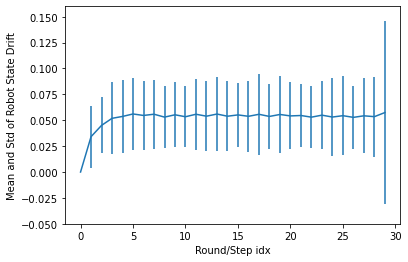

In [4]:
#Compute Mean error for success
success_mean_error = np.mean(success_error_all,axis=0)
success_std_error = np.std(success_error_all,axis=0)
stepIdx = np.array([i for i in range(30)])
print("mean error for sucess: ", success_mean_error)
print("std error for sucess: ", success_std_error)
fig=plt.figure();   ax = fig.gca()
plt.errorbar(stepIdx, success_mean_error, success_std_error)
ax.set_xlabel("Round/Step idx")
ax.set_ylabel("Mean and Std of Robot State Drift")
ax.set_ylim([-0.05,0.16])
plt.show()

mean error for fail:  [0.1587 0.0788 0.0594 0.0524 0.0484 0.0482 0.0476 0.0465 0.0465 0.045
 0.045  0.045  0.0453 0.044  0.0435 0.0433 0.0412 0.0405 0.0401 0.0394
 0.0387 0.0377 0.0375 0.0362 0.0357 0.0352 0.0342 0.0338]
std error for fail:  [0.4216 0.141  0.0659 0.0324 0.0261 0.0305 0.0303 0.0283 0.0308 0.0279
 0.0295 0.0316 0.0328 0.0292 0.0296 0.0316 0.0292 0.0275 0.0276 0.0292
 0.0316 0.028  0.0313 0.0271 0.0267 0.0272 0.0258 0.0256]


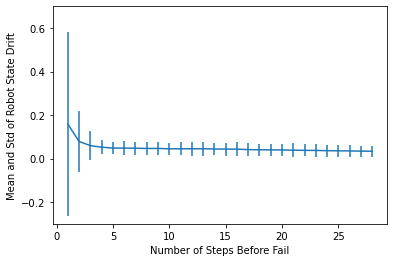

In [5]:
#Compute Mean error for failed
failed_mean_error = []
failed_std_error = []

for i in range(0,maxStepIndexbeforeFail):
    templist = []
    for j in range(len(failed_error_all)):
        if i <= len(failed_error_all[j]) - 1:
            templist.append(failed_error_all[j][i])

    temp_mean = np.mean(templist)
    temp_std = np.std(templist)

    failed_mean_error.append(temp_mean)
    failed_std_error.append(temp_std)

failed_mean_error = np.array(failed_mean_error)
failed_std_error = np.array(failed_std_error)

print("mean error for fail: ", failed_mean_error)
print("std error for fail: ", failed_std_error)
fig=plt.figure();   ax = fig.gca()
stepIdx = np.array([i for i in range(1, maxStepIndexbeforeFail+1)])
plt.errorbar(stepIdx, failed_mean_error, failed_std_error)
ax.set_xlabel("Number of Steps Before Fail")
ax.set_ylabel("Mean and Std of Robot State Drift")
ax.set_ylim([-0.3,0.7])
plt.show()

In [6]:
print("Large Error Threshold: ",diff_threshold)
print("Number of Steps Larger than the threshold: ", large_error_cnt)

Large Error Threshold:  0.04
Number of Steps Larger than the threshold:  60799
